In [1]:
from params import *
from Dataset import get_dataloader
from Model import SKModel

import numpy as np
import pandas as pd

import IPython
import matplotlib.pyplot as plt
import matplotlib.backend_bases as mpl

%matplotlib widget
import seaborn as sns

import os
import shutil
import glob
import time
import sys

import re
import pretty_midi
import librosa

from sklearn.linear_model import SGDRegressor, Perceptron, LogisticRegression
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LearningCurveDisplay, train_test_split
from sklearn.metrics import classification_report, accuracy_score

import torch
import torchaudio

from mido import MidiFile
from guppy import hpy


%load_ext autoreload
%autoreload 2


# Looking at our data

### Metadata

In [2]:
mid = pretty_midi.PrettyMIDI('data/musicnet_midis/Schubert/1727_schubert_op114_2.mid')
mid.instruments

[Instrument(program=40, is_drum=False, name="Violin"),
 Instrument(program=41, is_drum=False, name="Viola"),
 Instrument(program=42, is_drum=False, name="Cello"),
 Instrument(program=43, is_drum=False, name="Contrabass"),
 Instrument(program=0, is_drum=False, name="Pianoforte")]

In [3]:
meta = pd.read_csv(r"data\musicnet_metadata.csv")
meta.head(3)

id  composer               composition                   movement  \
0  1727  Schubert  Piano Quintet in A major                 2. Andante   
1  1728  Schubert  Piano Quintet in A major         3. Scherzo: Presto   
2  1729  Schubert  Piano Quintet in A major  4. Andantino - Allegretto   

        ensemble            source                      transcriber  \
0  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
1  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
2  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   

  catalog_name  seconds  
0        OP114      447  
1        OP114      251  
2        OP114      444

In [4]:
meta = meta.drop(columns=["composition","movement", "ensemble", "source", "transcriber", "catalog_name"])
meta.head(5)

id  composer  seconds
0  1727  Schubert      447
1  1728  Schubert      251
2  1729  Schubert      444
3  1730  Schubert      368
4  1733  Schubert      546

In [5]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        330 non-null    int64 
 1   composer  330 non-null    object
 2   seconds   330 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ KB


Total length: 122709 seconds!


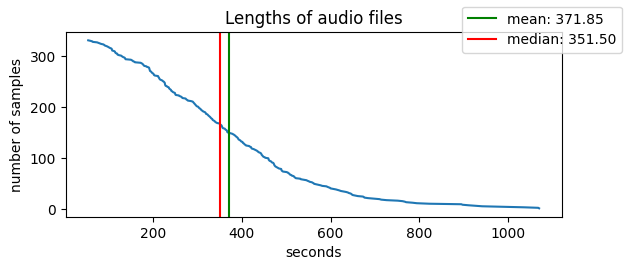

In [6]:
seconds = meta.seconds.sort_values().reset_index(drop=True).value_counts().sort_index(ascending=False)
fig, ax1 = plt.subplots(1,figsize=(6.4,2.4))
ax1.plot(seconds.index,seconds.cumsum())
ax1.axvline(meta.seconds.mean(),color='g',label=f"mean: {meta.seconds.mean():.2f}")
ax1.axvline(meta.seconds.median(),color='r',label=f"median: {meta.seconds.median():.2f}")
fig.legend()
ax1.set_xlabel("seconds")
ax1.set_ylabel("number of samples")
ax1.set_title("Lengths of audio files")
print(f"Total length: {meta.seconds.sum()} seconds!")
plt.close()
fig


Taking only 5 seconds from each sample will get us roughly ~367 different samples per file totaling at about ~121050 different samples!

### Sound files

AudioMetaData(sample_rate=44100, num_frames=19715328, num_channels=1, bits_per_sample=32, encoding=PCM_F)
number of features: 19715328


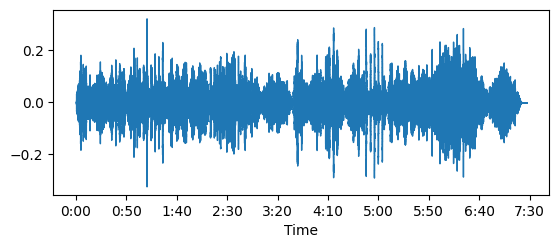

In [3]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH)

print(torchaudio.info(AUDIO_EXAMPLE_PATH))
print("number of features: {}".format(len(samples1[0])))

fig, ax1 = plt.subplots(1,figsize=(6.4,2.4))
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1)
plt.close()
fig

We take only a sample of the initial audio file and reduce the sampling rate to get a dramatic decrease in number of features

number of features 1: 220500, number of features 2: 40000


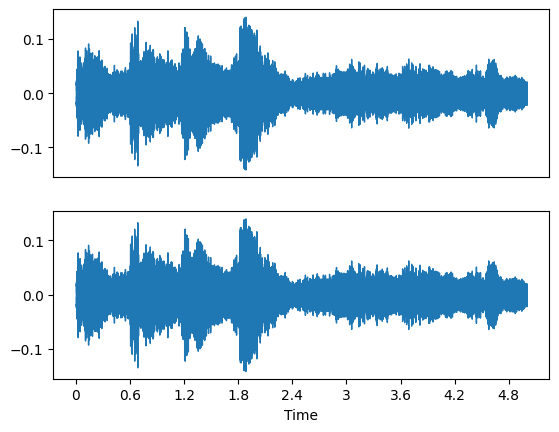

In [8]:
#Sample from second 8
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

print("number of features 1: {}, number of features 2: {}".format(len(samples1[0]),len(samples2[0])))

fig, (ax1,ax2) = plt.subplots(2,1)
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1,axis=None)
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=ax2)
plt.close()
fig

In [9]:
IPython.display.display(IPython.display.Audio(samples1,rate=sr1))
IPython.display.display(IPython.display.Audio(samples2,rate=SAMPLING_RATE))


We lose some audio quality but really not that much!

# Creating our dataset

run this cell once

In [10]:
#Move the files to the desired directory
def create_dataset(df:pd.DataFrame):
    samples = {sample[:-4]:"train" for sample in  os.listdir('data/musicnet/train_data')}
    samples.update({sample[:-4]:"test" for sample in  os.listdir('data/musicnet/test_data')})
    
    instrument_data = []
    
    for path in glob.glob('data/musicnet_midis/*/*.mid'):
        id = re.sub("_.*","",os.path.basename(path))
        if id in samples:
            #keep only samples where we can access the midi file
            try: 
                mid = pretty_midi.PrettyMIDI(path)

                #load and save wav files as tensors
                sample_data,sr = torchaudio.load(f"data/musicnet/{samples[id]}_data/{id}.wav")
                sample_data = torchaudio.functional.resample(sample_data,sr,SAMPLING_RATE)
                torch.save(sample_data,f'data\{samples[id]}\{id}.pt')


                #Create instrument labels
                label = {"id":int(id), "path":f'data\{samples[id]}\{id}.pt', "train":samples[id]=="train"}
                label.update({instrument.program:1 for instrument in  mid.instruments})
                instrument_data.append(label)

            #remove "bad" samples
            except:
                print(f"could not load file: {path}")
                shutil.move(f"data/musicnet/{samples[id]}_data/{id}.wav",f"data/bad_data/{samples[id]}_data/{id}.wav")

    instrument_df = pd.DataFrame.from_records(instrument_data)
    return df.merge(instrument_df, on="id",how="right")

#Create the new metadata only if it doesnt exists
if os.path.exists(RAW_LABELS_CSV_DIR) == False:
    df = create_dataset(meta)
    df.to_csv(RAW_LABELS_CSV_DIR,index=False)

df = pd.read_csv(RAW_LABELS_CSV_DIR)

## Data labeling

In [11]:
df = df[df["train"]]
df = df.drop(columns="train").reset_index(drop=True)
df.head(5)

id composer  seconds                path   40   41    0  73  42   6  45  \
0  2186     Bach      214  data\train\2186.pt  1.0  1.0  NaN NaN NaN NaN NaN   
1  2195     Bach      155  data\train\2195.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
2  2196     Bach       75  data\train\2196.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
3  2198     Bach      197  data\train\2198.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
4  2200     Bach      113  data\train\2200.pt  NaN  NaN  1.0 NaN NaN NaN NaN   

   71  70  60  68  43  
0 NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN

Setting NaN values to 0

In [12]:
FIRST_COLS = ["id", "composer", "seconds", "path"]
def populate_dataset(df:pd.DataFrame):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    df = df.fillna(0)
    df = df.loc[:,  FIRST_COLS + numerical_cols]
    df = df.set_index("id")
    
    return df 

df = populate_dataset(df)
df.head(5)

composer  seconds                path    0   40   41   42   43   45    6  \
id                                                                              
2186     Bach      214  data\train\2186.pt  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2195     Bach      155  data\train\2195.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2196     Bach       75  data\train\2196.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2198     Bach      197  data\train\2198.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2200     Bach      113  data\train\2200.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

       60   68   70   71   73  
id                             
2186  0.0  0.0  0.0  0.0  0.0  
2195  0.0  0.0  0.0  0.0  0.0  
2196  0.0  0.0  0.0  0.0  0.0  
2198  0.0  0.0  0.0  0.0  0.0  
2200  0.0  0.0  0.0  0.0  0.0

In [13]:
def plot_data_dis(df,fig,ax1,ax2,with_unique=True):
    def onPick(event:mpl.PickEvent):
        numerical_cols = list(df.columns.difference(FIRST_COLS))
        
        if event.mouseevent.button != 1:
            return

        del_patch = False
        patches = ax1.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                del_patch = True
                
        patches = ax2.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                del_patch = True
        
        if del_patch and with_unique:
            y = df.drop_duplicates()[numerical_cols].sum()
            y = y[y>0]
            info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
            p = ax1.bar(y.index,y,color='tab:orange',picker=8)
            ax1.bar_label(p,label_type='center',labels=info,picker=8)


            y = df.drop_duplicates()['composer'].value_counts().astype(int)
            info = ["{}\n{:.2%}".format(v,v/ax2_y[k]) for k,v in y.items() ]
            p = ax2.bar(y.index,y,picker=8,color='tab:orange')
            ax2.bar_label(p,label_type='center',labels=info,picker=8)
            
            
            return
        
        patches = ax1.get_children()
        for p in patches:
            if p.properties()["picker"] == 8:
                p.remove()
                
                
        patches = ax2.get_children()
        for p in patches:
            if p.properties()["picker"] == 8:
                p.remove()


        num = int(np.rint(event.mouseevent.xdata))
        if event.mouseevent.inaxes.get_title() == "Composer distribution":
            #clicked on composer
            if num in range(len(ax2_x)):
                #Instruments with composer
                y = df[df['composer']==ax2_x.index[num]][numerical_cols].sum()
                y = y[y>0]
                info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
                p = ax1.bar(y.index,y,label=ax2_x.index[num],picker=5,color='tab:green')
                ax1.bar_label(p,label_type='center',labels=info,picker=5)
                #composer selected
                p = ax2.bar(ax2_x.index[num],ax2_y[ax2_x.index[num]],label=ax2_x.index[num],picker=5,color='tab:green')
                
                if with_unique:
                    #unique samples
                    y = df.drop_duplicates()[df.drop_duplicates()['composer']==ax2_x.index[num]][numerical_cols].sum()
                    y = y[y>0]
                    p = ax1.bar(y.index,y,color="tab:orange",picker=5)
                    
                    #composer
                    ax2.bar(ax2_x.index[num],df.drop_duplicates()['composer'].value_counts().astype(int)[ax2_x.index[num]],picker=5,color="tab:orange")
                
        else:
            if num in range(len(numerical_cols)):
                
                #Instruments played together
                y = df[numerical_cols][df[numerical_cols[num]] == 1].sum()
                y = y[y>0]
                info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
                p = ax1.bar(y.index,y,label=numerical_cols[num],picker=5,color='tab:green')
                ax1.bar_label(p,label_type='center',labels=info,picker=5)

                #Composers that played instrument
                y = df[df[numerical_cols[num]] == 1]['composer'].value_counts().astype(int)
                info = ["{}\n{:.2%}".format(v,v/ax2_y[k]) for k,v in y.items() ]
                p = ax2.bar(y.index,y,label=numerical_cols[num],picker=5,color='tab:green')
                ax2.bar_label(p,label_type='center',labels=info,picker=5)


                #unique samples
                if with_unique:
                    #Instruments played together
                    y = df.drop_duplicates()[numerical_cols][df.drop_duplicates()[numerical_cols[num]] == 1].sum()
                    y = y[y>0]
                    p = ax1.bar(y.index,y,label=numerical_cols[num],picker=5,color="tab:orange")

                    #Composers that played instrument
                    y = df.drop_duplicates()[df.drop_duplicates()[numerical_cols[num]] == 1]['composer'].value_counts().astype(int)
                    p = ax2.bar(y.index,y,label=numerical_cols[num],picker=5,color="tab:orange")

            
    
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    ax1_x = (df[numerical_cols].sum()*0+1).cumsum()-1
    ax1_y = df[numerical_cols].sum()
    p = ax1.bar(ax1_x.index, ax1_y,picker=True)
    ax1.bar_label(p,fmt=lambda h: "{}\n{:.2%}".format(int(h),h/len(df)))

    if with_unique:
        y = df.drop_duplicates()[numerical_cols].sum()
        y = y[y>0]
        info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
        p = ax1.bar(y.index,y,color='tab:orange',picker=8)
        ax1.bar_label(p,label_type='center',labels=info,picker=8)

    ax1.set_xticks(ax1_x)
    ax1.set_xticklabels(ax1_x.index)
    ax1.set_title("Instrument occurrences")
    ax1.set_ylabel("# Samples")
    ax1.set_xlabel("Instrument number")


    ax2_x = (df.composer.value_counts().sort_index()*0 + 1).cumsum()-1
    ax2_y = df.composer.value_counts().sort_index()
    ax2.bar(ax2_x.index, ax2_y,picker=True,label="all samples")
    for i in ax2_x.index:
        ax2.text(i,ax2_y[i],ax2_y[i], horizontalalignment='center',va='bottom')
    x_labels = ax2_x.index

    if with_unique:
        y = df.drop_duplicates()['composer'].value_counts().astype(int)
        info = ["{}\n{:.2%}".format(v,v/ax2_y[k]) for k,v in y.items() ]
        p = ax2.bar(y.index,y,picker=8,color='tab:orange',label="unique samples")
        ax2.bar_label(p,label_type='center',labels=info,picker=8)



    ax2.set_xticks(ax2_x)
    ax2.set_xticklabels(x_labels)
    ax2.set_ylabel("# Samples")
    ax2.set_xlabel("Composer")
    ax2.set_title("Composer distribution")
    
    fig.canvas.mpl_connect('pick_event',onPick)
    fig.legend()
    return ax1,ax2



Try clicking on instruments

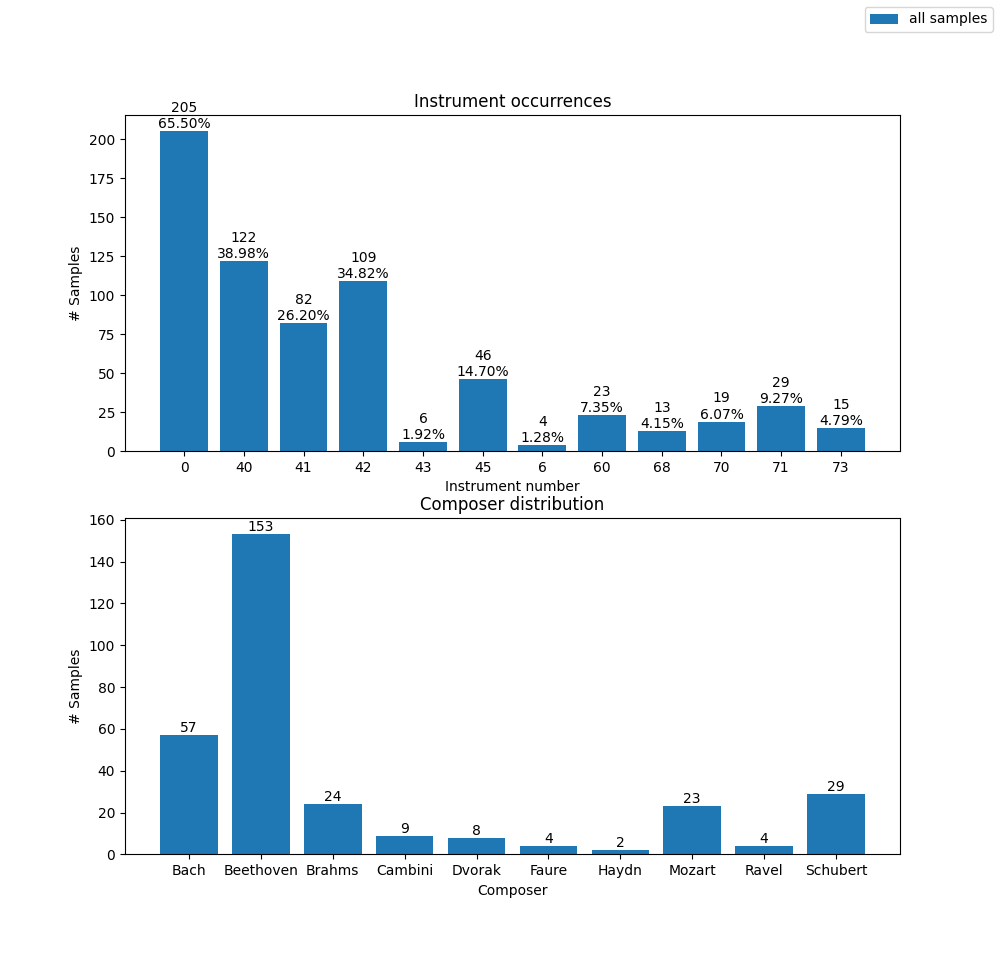

In [14]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2,with_unique=False)
plt.show()

### Cleaning Data

Removing labels that have a low amount of samples

In [15]:
def remove_outliers(df,min_instrument=10, min_composer=5, iters=5):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    drop_composers = []
    for _ in range(iters):
        mask = (df[numerical_cols].sum() < min_instrument) &  (df[numerical_cols].sum() != 0)
        drop1 = mask[mask==True].index
        for i in drop1:
            df = df[df[i]!=1]

        mask = (df.composer.value_counts()<min_composer)
        drop2 = mask[mask==True].index
        
        if len(drop1)==0 and len(drop2)==0: 
            break

        for i in drop2:
            df = df[df["composer"] != i]
            drop_composers.append(i)

    
    mask = (df[numerical_cols].sum() == 0) 
    drop_instruments = mask[mask==True].index
    df = df.drop(columns=drop_instruments)
    return df, drop_instruments, drop_composers

Setting a hard limit on the number of samples in the dataset

Note: during training and testing each one label may correspond to multiple samples from the same audio file

In [16]:
def getSamples(df,composer,n_samples,low_count_priority = True, replace=False):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    sizes = df[df['composer']==composer][numerical_cols].groupby(numerical_cols).size()
    if low_count_priority:
        sizes = (sizes - sizes.max()).abs() + 1
    if sizes.max() == 0:
        sizes = sizes + 1
    
    sizes = sizes.reset_index(name='Count')
    
    
    sizes = sizes.merge(df[df['composer']==composer].reset_index(),on=numerical_cols,how="inner").set_index('id')
    return sizes.sample(n_samples,weights="Count",random_state=SEED,replace=replace).drop(columns='Count')


In [17]:
def drop_excess_samples(df):
    while df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES > 0:
        
        n = df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES
        composer = df['composer'].value_counts().idxmax()
        df = df.drop(index=getSamples(df,composer,n,low_count_priority=False).index)
    return df

Ensure we have the same number of composers for a more accurate evaluation

In [18]:
def balance_composers(df,max_samples=MAX_COMPOSER_SAMPLES):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    temp = df['composer'].value_counts() < max_samples
    for comp in temp.index:
        n = max_samples-df['composer'].value_counts()[comp]
        if n >0:
            inc = max(1,n//len(numerical_cols))
            while n > 0:

                composer_samples = getSamples(df,comp,min(n,inc),low_count_priority=True,replace=True)
                n = n-inc
                df = pd.concat([df, composer_samples])
    return df

In [19]:
df, drop_instruments, drop_composers = remove_outliers(df)
df = drop_excess_samples(df)
df = balance_composers(df)
df

composer  seconds                path    0   40   41   42   45   60   68  \
id                                                                              
2186     Bach      214  data\train\2186.pt  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2195     Bach      155  data\train\2195.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2196     Bach       75  data\train\2196.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2198     Bach      197  data\train\2198.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2200     Bach      113  data\train\2200.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
...       ...      ...                 ...  ...  ...  ...  ...  ...  ...  ...   
1916   Dvorak      675  data\train\1916.pt  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1922   Dvorak      402  data\train\1922.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1916   Dvorak      675  data\train\1916.pt  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1923   Dvorak      393  data\train\1923.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1923   Dvorak      393  data\train\1923.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   

       70   71   73  
id                   
2186  0.0  0.0  0.0  
2195  0.0  0.0  0.0  
2196  0.0  0.0  0.0  
2198  0.0  0.0  0.0  
2200  0.0  0.0  0.0  
...   ...  ...  ...  
1916  0.0  0.0  0.0  
1922  0.0  0.0  0.0  
1916  0.0  0.0  0.0  
1923  0.0  0.0  0.0  
1923  0.0  0.0  0.0  

[595 rows x 13 columns]

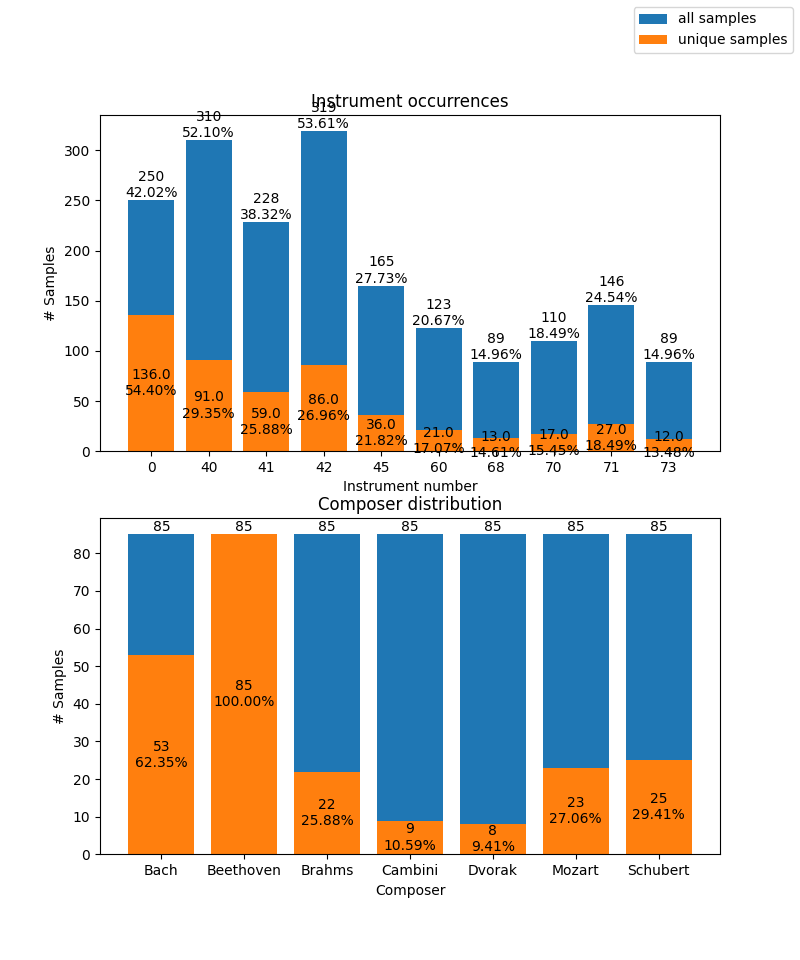

In [20]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)
plt.show()

In [21]:
df.nunique()

composer      7
seconds     189
path        225
0             2
40            2
41            2
42            2
45            2
60            2
68            2
70            2
71            2
73            2
dtype: int64

## Test set

Since the test set from kaggle is small we will ensure the testing set has at least one sample from each class

In [22]:
def modify_test(test_df:pd.DataFrame,train_df:pd.DataFrame,drop_composers,drop_instruments,sample_train=1):
    
    for comp in drop_composers:
        test_df = test_df[test_df["composer"] != comp]
    for inst in drop_instruments:
        test_df = test_df[test_df[inst] != 1]
    test_df = test_df.drop(columns=drop_instruments)


    #Test is quite small so we artificially create more samples by taking away from train
    numerical_cols = np.sort(train_df.columns.difference(FIRST_COLS)).tolist()
    #ensure at least 1 sample from each class
    a = train_df.groupby(numerical_cols,group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train,random_state=SEED),include_groups=True)
    b = train_df.groupby('composer',group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train,random_state=SEED),include_groups=True)
    test_df = pd.concat([test_df,a,b]).drop_duplicates()
    train_df = train_df.drop(pd.concat([a,b]).index)
    return test_df,train_df
    

In [23]:
def load_data():
    
    if os.path.exists(RAW_LABELS_CSV_DIR) == False:
        df = create_dataset(meta)
        df.to_csv(RAW_LABELS_CSV_DIR)
    df = pd.read_csv(RAW_LABELS_CSV_DIR)
    train_df = df[df["train"]==True].drop(columns="train").reset_index(drop=True)
    test_df =  df[df["train"]==False].drop(columns="train").reset_index(drop=True)
    
    train_df = populate_dataset(train_df)
    test_df = populate_dataset(test_df)

    train_df,drop_instruments,drop_composers = remove_outliers(train_df)
    test_df,train_df = modify_test(test_df,train_df,drop_composers,drop_instruments)
    print("Test size:",len(test_df))


    X = train_df.index.unique()
    train_idx, val_idx, _, _ = train_test_split(X,X,test_size=SPLIT_SIZE,random_state=SEED)
    
    val_df = train_df.loc[val_idx]
    train_df = train_df.loc[train_idx]
    

    train_df = drop_excess_samples(train_df)
    print('"Unique" train samples:',len(train_df))
    print('"Unique" validation samples:',len(val_df))

    train_df = balance_composers(train_df)
    val_df = balance_composers(val_df,val_df["composer"].value_counts().max())
    print("Total train size:",len(train_df))
    print("Total validation size:",len(val_df))
    

    le = LabelEncoder()
    train_df["composer"] = le.fit_transform(train_df["composer"])
    test_df["composer"] = le.transform(test_df["composer"])
    val_df["composer"] = le.transform(val_df["composer"])

    return train_df, val_df, test_df, le

train_df,val_df,test_df,encoder =  load_data()
del df

Test size: 37
"Unique" train samples: 167
"Unique" validation samples: 80
Total train size: 595
Total validation size: 273


In [24]:
val_df.composer.unique()

array([1, 5, 0, 6, 3, 4, 2])

In [25]:
train_df.composer.unique()

array([1, 0, 5, 2, 6, 4, 3])

In [26]:
def getClasses(df):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    return [[0,1] for i in range(len(numerical_cols)) ], df.composer.unique()

INSTRUMENT_CLASSES, COMPOSER_CLASSES = getClasses(train_df)

# Data loading
### Train - Val split

In [27]:
train_x = train_df.path.to_numpy()
train_y = train_df
val_x = val_df.path.to_numpy()
val_y = val_df
test_x = test_df.path.to_numpy()
test_y = test_df

In [28]:
train_x.shape, val_x.shape, test_x.shape

((595,), (273,), (37,))

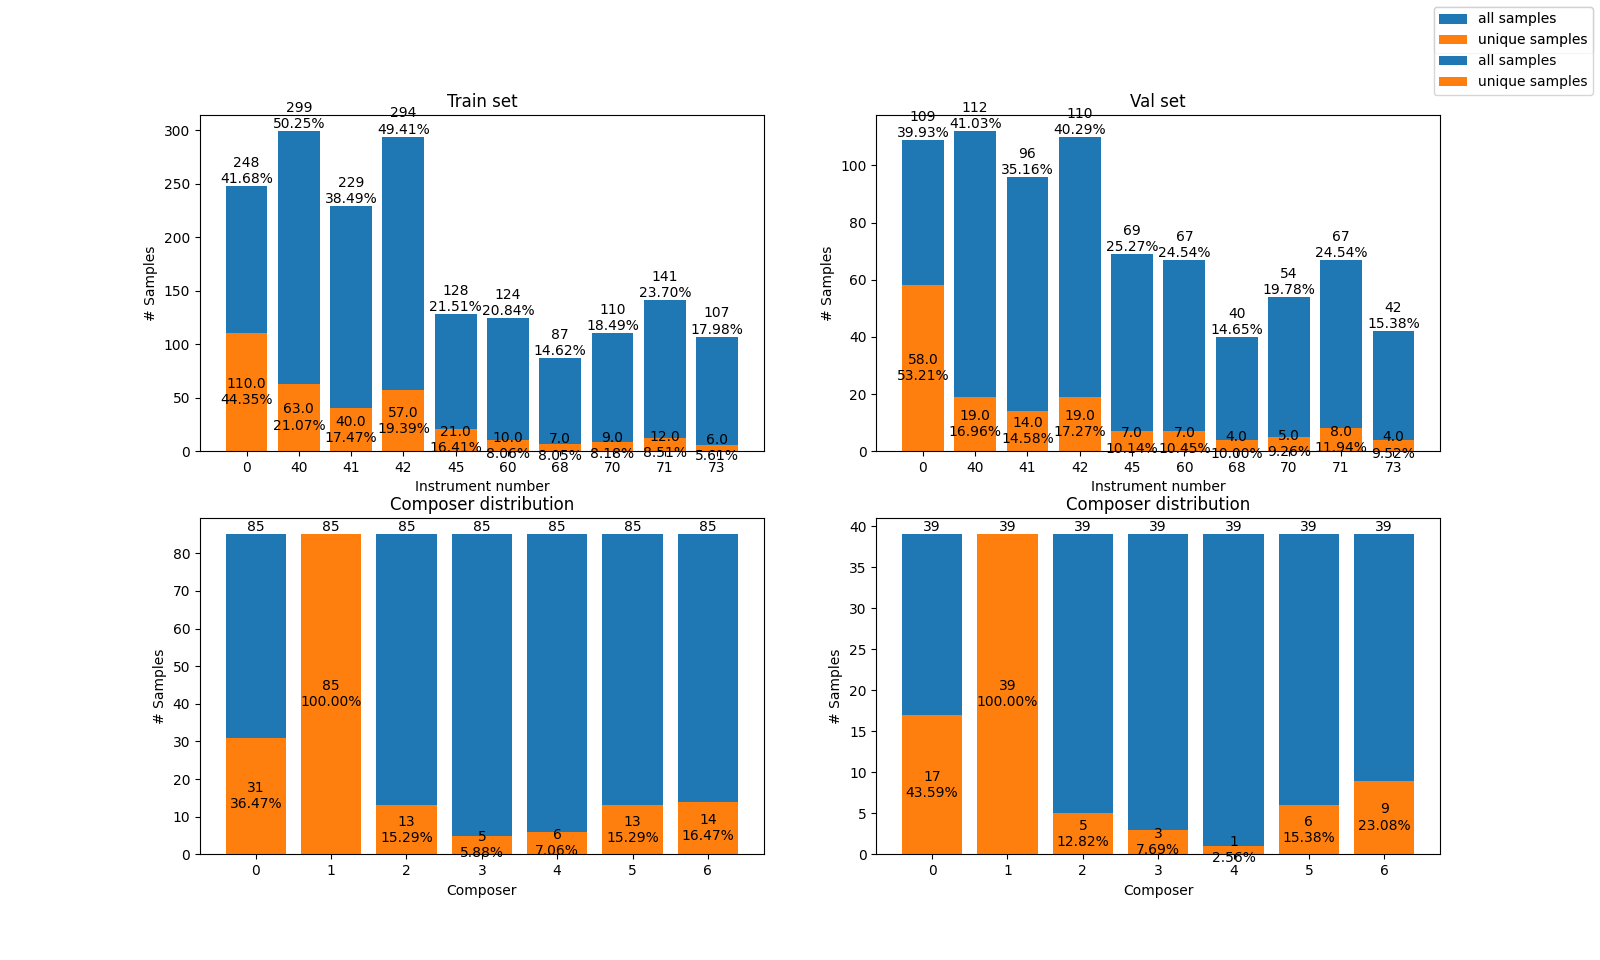

In [29]:
fig, axes = plt.subplots(2,2,figsize=(16,9.6))
y1 = train_y
y2 = val_y
plot_data_dis(y1,fig,axes[0,0],axes[1,0])
plot_data_dis(y2,fig,axes[0,1],axes[1,1])
axes[0,0].set_title("Train set")
axes[0,1].set_title("Val set")
plt.show()

We will be using pytorch's dataloader to load batches of data, for more info go to dataset.py

## Benchmarking

In [30]:
def mean_time(epoches,loader):
    total_time = 0
    total_samples = 0
    total_batches = 0
    for i in range(epoches):
        num_samples = 0
        num_batches = 0
        total_epoch_time = 0
        sample = torch.zeros(1)
        start = time.time()
        for s in loader:
            sample_time = time.time() - start
            
            sample = s[0]
            total_epoch_time += sample_time
            num_samples += len(s[0])
            num_batches += 1
            start = time.time()

        total_batches += num_batches
        total_samples += num_samples
        total_time += total_epoch_time

        avg_batch_time = total_epoch_time/num_batches
        avg_sample_time = total_epoch_time/num_samples
        print("Device: {}, Total run time for epoch {}: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(sample.device,i,total_epoch_time,avg_batch_time,avg_sample_time))

    avg_epoch_time = total_time/epoches
    avg_sample_time = total_time/total_samples
    avg_batch_time = total_time/total_batches
    print("--------------------------------------------------------------------")
    print("Total run time for {} epoches: {:.3f}, Average epoch time: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(epoches,total_time,avg_epoch_time,avg_batch_time,avg_sample_time))


In [31]:
train_ds,train_loader = get_dataloader(train_x,train_y,64,mode=0)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cpu, Total run time for epoch 0: 2.7830, Average batch load time: 0.27830, Average sample load time: 0.004677
Device: cpu, Total run time for epoch 1: 2.6820, Average batch load time: 0.26820, Average sample load time: 0.004508
Device: cpu, Total run time for epoch 2: 2.8235, Average batch load time: 0.28235, Average sample load time: 0.004745
Device: cpu, Total run time for epoch 3: 2.8065, Average batch load time: 0.28065, Average sample load time: 0.004717
Device: cpu, Total run time for epoch 4: 2.6415, Average batch load time: 0.26415, Average sample load time: 0.004439
Device: cpu, Total run time for epoch 5: 2.5795, Average batch load time: 0.25795, Average sample load time: 0.004335
Device: cpu, Total run time for epoch 6: 2.5745, Average batch load time: 0.25745, Average sample load time: 0.004327
Device: cpu, Total run time for epoch 7: 2.5815, Average batch load time: 0.25815, Average sample load time: 0.004339
Device: cpu, Total run time for epoch 8: 2.6760, Average

In [32]:
train_ds,train_loader = get_dataloader(train_x,train_y,64,mode=0,cache_size=400)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cpu, Total run time for epoch 0: 3.6885, Average batch load time: 0.36885, Average sample load time: 0.006199
Device: cpu, Total run time for epoch 1: 0.9725, Average batch load time: 0.09725, Average sample load time: 0.001634
Device: cpu, Total run time for epoch 2: 1.0840, Average batch load time: 0.10840, Average sample load time: 0.001822
Device: cpu, Total run time for epoch 3: 1.0485, Average batch load time: 0.10485, Average sample load time: 0.001762
Device: cpu, Total run time for epoch 4: 1.1005, Average batch load time: 0.11005, Average sample load time: 0.001850
Device: cpu, Total run time for epoch 5: 1.1145, Average batch load time: 0.11145, Average sample load time: 0.001873
Device: cpu, Total run time for epoch 6: 1.1750, Average batch load time: 0.11750, Average sample load time: 0.001975
Device: cpu, Total run time for epoch 7: 1.0840, Average batch load time: 0.10840, Average sample load time: 0.001822
Device: cpu, Total run time for epoch 8: 1.0575, Average

In [33]:
train_ds,train_loader = get_dataloader(train_x,train_y,64,mode=0,preload=True)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cpu, Total run time for epoch 0: 0.2375, Average batch load time: 0.02375, Average sample load time: 0.000399
Device: cpu, Total run time for epoch 1: 0.2500, Average batch load time: 0.02500, Average sample load time: 0.000420
Device: cpu, Total run time for epoch 2: 0.2575, Average batch load time: 0.02575, Average sample load time: 0.000433
Device: cpu, Total run time for epoch 3: 0.2190, Average batch load time: 0.02190, Average sample load time: 0.000368
Device: cpu, Total run time for epoch 4: 0.2350, Average batch load time: 0.02350, Average sample load time: 0.000395
Device: cpu, Total run time for epoch 5: 0.2405, Average batch load time: 0.02405, Average sample load time: 0.000404
Device: cpu, Total run time for epoch 6: 0.2375, Average batch load time: 0.02375, Average sample load time: 0.000399
Device: cpu, Total run time for epoch 7: 0.2170, Average batch load time: 0.02170, Average sample load time: 0.000365
Device: cpu, Total run time for epoch 8: 0.2590, Average

In [34]:
#faster then cache, but will use up too much memory from the gpu
train_ds,train_loader = get_dataloader(train_x,train_y,64,mode=2,preload=True,device=DEVICE)
mean_time(10,train_loader)
del train_ds
del train_loader

Device: cuda:0, Total run time for epoch 0: 0.6345, Average batch load time: 0.06345, Average sample load time: 0.001066
Device: cuda:0, Total run time for epoch 1: 0.4605, Average batch load time: 0.04605, Average sample load time: 0.000774
Device: cuda:0, Total run time for epoch 2: 0.4460, Average batch load time: 0.04460, Average sample load time: 0.000750
Device: cuda:0, Total run time for epoch 3: 0.4535, Average batch load time: 0.04535, Average sample load time: 0.000762
Device: cuda:0, Total run time for epoch 4: 0.4475, Average batch load time: 0.04475, Average sample load time: 0.000752
Device: cuda:0, Total run time for epoch 5: 0.4545, Average batch load time: 0.04545, Average sample load time: 0.000764
Device: cuda:0, Total run time for epoch 6: 0.4780, Average batch load time: 0.04780, Average sample load time: 0.000803
Device: cuda:0, Total run time for epoch 7: 0.4925, Average batch load time: 0.04925, Average sample load time: 0.000828
Device: cuda:0, Total run time f

In [35]:
train_ds,train_loader = get_dataloader(train_x,train_y,128,mode=0,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,val_y,100,mode=0,cache_size=200)

In [36]:
a,l1 = train_ds[0]
b,l2 = train_ds[0]
#Each item in the dataloader samples a random section of the audio file. We may get many samples that all match the same label
(a-b).sum(), l1[0] == l2[0], all(l1[1]==l2[1])

(tensor(0.8590), True, True)

In [37]:
del a,l1,b,l2

Dataset generator for offline models

In [38]:
def generate_samples(loader,factor = 1):
    samples_x = []
    samples_y1 = []
    samples_y2 = []
    for i in range(factor):
        for x,y in loader:
            samples_x = samples_x + x.tolist()
            samples_y1 = samples_y1 + y[0].tolist()
            samples_y2 = samples_y2 + y[1].tolist()

    return np.array(samples_x), (np.array(samples_y1), np.array(samples_y2))


# Training

For now let's focus on composer only

In [39]:
#Not many samples at all!!
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

x,y = generate_samples(train_loader,1)
xVal,yVal = generate_samples(val_loader,1)
x.shape

(595, 40000)

In [40]:
pipe = make_pipeline(StandardScaler())
x = pipe.fit_transform(x)
xVal = pipe.transform(xVal)
x.shape

(595, 40000)

## Offline models (attempt)

- KNN
- Adaboost

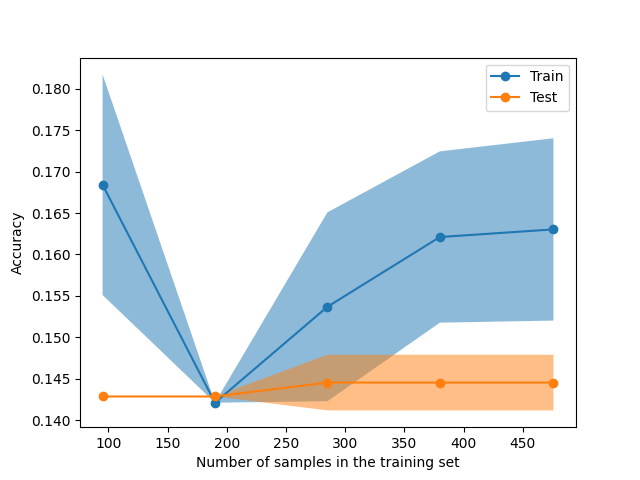

In [41]:
common_params = {
    "X": x,
    "y": y[0],
    "train_sizes": np.linspace(0.2, 1.0, 5),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
    "random_state":SEED
}

knn_model = KNeighborsClassifier(5,n_jobs=-1)
LearningCurveDisplay.from_estimator(knn_model, **common_params)

Let's try a much complex model

c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=LogisticRegression(n_jobs=-1, random_state=12),
                   random_state=12)

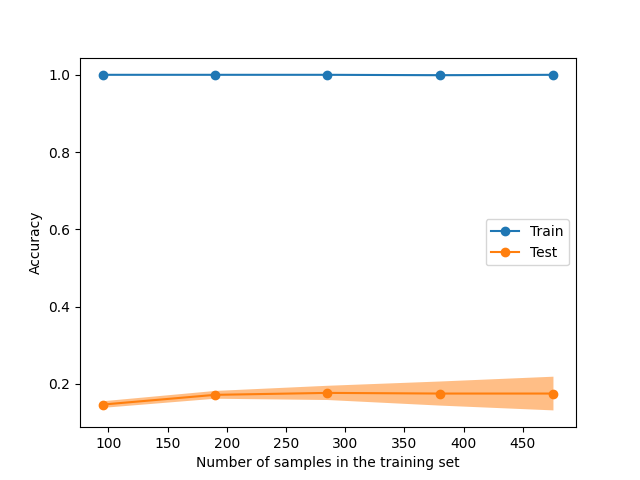

In [42]:
weak_model = LogisticRegression(n_jobs=-1,random_state=SEED)
model_adaboost = AdaBoostClassifier(weak_model,n_estimators=50,random_state=SEED)
LearningCurveDisplay.from_estimator(model_adaboost, **common_params)
model_adaboost.fit(x,y[0])

In [43]:
x2,y2 = generate_samples(train_loader,1)
x2 = pipe.transform(x2)
pred = model_adaboost.predict(x2)
print(classification_report(y2[0],pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.26      0.14      0.18        85
           2       0.21      0.08      0.12        85
           3       0.21      0.06      0.09        85
           4       0.30      0.04      0.06        85
           5       0.25      0.06      0.10        85
           6       0.15      0.79      0.25        85

    accuracy                           0.17       595
   macro avg       0.20      0.17      0.11       595
weighted avg       0.20      0.17      0.11       595



### Dimensionality reduction 

In [44]:
del x,y,xVal,yVal
x,y = generate_samples(train_loader,10)
xVal,yVal = generate_samples(train_loader,1)
x.shape

(5950, 40000)

In [45]:
pca = PCA()
pca.fit(x)

PCA()

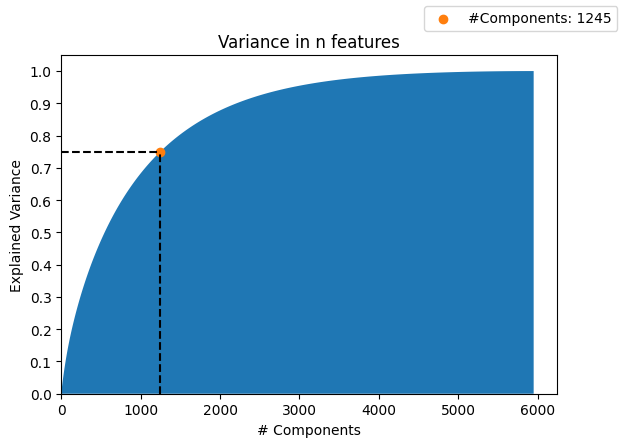

In [46]:
fig, ax1 = plt.subplots(1,figsize=(6.4,4.4))
acc_var = np.cumsum(pca.explained_variance_ratio_)
ax1.fill_between(1+np.arange(len(acc_var)),acc_var)
n_features = np.argmin(np.abs(acc_var - 0.75))
ax1.vlines(n_features+1,0,acc_var[n_features],linestyles='dashed',color='black')
ax1.hlines(acc_var[n_features],0,n_features+1,linestyles='dashed',color='black')
ax1.set_yticks(np.arange(11)/10)
ax1.set_xlim(0,None)
ax1.set_ylim(0,None)
ax1.set_ylabel("Explained Variance")
ax1.set_xlabel("# Components")
ax1.set_title("Variance in n features")
ax1.scatter(n_features+1,acc_var[n_features], label=f"#Components: {n_features}")
fig.legend()
plt.close()
fig

In [47]:
pipe = make_pipeline(StandardScaler(),PCA(n_components=min(n_features,len(x)),random_state=SEED))
x = pipe.fit_transform(x)
xVal = pipe.transform(xVal)
x.shape

(5950, 1245)

### KNN and AdaBoost again

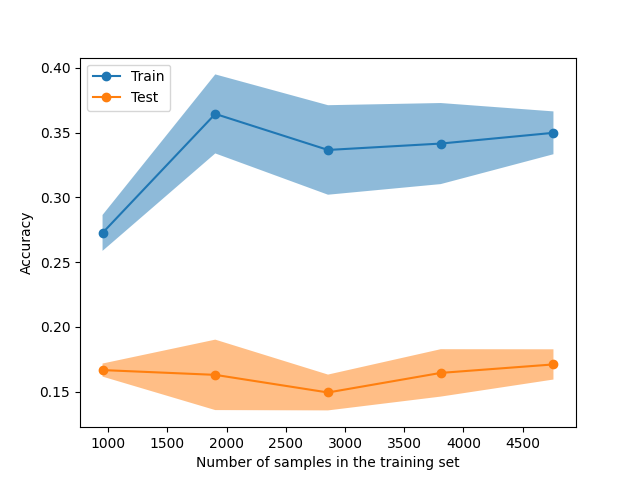

In [50]:
common_params = {
    "X": x,
    "y": y[0],
    "train_sizes": np.linspace(0.2, 1.0, 5),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
    "random_state":SEED
}
knn_model = KNeighborsClassifier(5,n_jobs=-1)
LearningCurveDisplay.from_estimator(knn_model, **common_params)

c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=LogisticRegression(n_jobs=-1, random_state=12),
                   random_state=12)

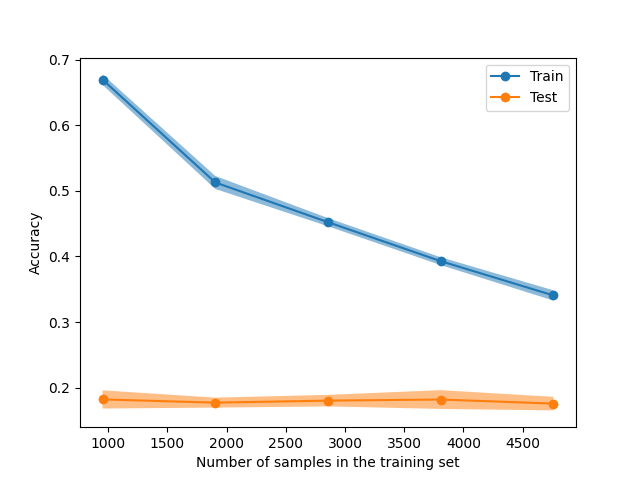

In [51]:
weak_model = LogisticRegression(n_jobs=-1,random_state=SEED)
model_adaboost = AdaBoostClassifier(weak_model,n_estimators=50,random_state=SEED)
LearningCurveDisplay.from_estimator(model_adaboost, **common_params)
model_adaboost.fit(x,y[0])

In [52]:
pred = model_adaboost.predict(x)
print(classification_report(y[0],pred))

              precision    recall  f1-score   support

           0       0.25      0.20      0.22       850
           1       0.26      0.25      0.26       850
           2       0.26      0.26      0.26       850
           3       0.24      0.24      0.24       850
           4       0.25      0.24      0.25       850
           5       0.31      0.31      0.31       850
           6       0.38      0.50      0.43       850

    accuracy                           0.29      5950
   macro avg       0.28      0.29      0.28      5950
weighted avg       0.28      0.29      0.28      5950



In [53]:
x2,y2 = generate_samples(train_loader,1)
x2 = pipe.transform(x2)
pred = model_adaboost.predict(x2)
print(classification_report(y2[0],pred))

              precision    recall  f1-score   support

           0       0.17      0.12      0.14        85
           1       0.15      0.15      0.15        85
           2       0.16      0.12      0.14        85
           3       0.16      0.18      0.17        85
           4       0.16      0.16      0.16        85
           5       0.12      0.13      0.13        85
           6       0.25      0.34      0.29        85

    accuracy                           0.17       595
   macro avg       0.17      0.17      0.17       595
weighted avg       0.17      0.17      0.17       595



In [54]:
pred = model_adaboost.predict(xVal)
print(classification_report(yVal[0],pred))

              precision    recall  f1-score   support

           0       0.20      0.13      0.16        85
           1       0.14      0.13      0.13        85
           2       0.20      0.18      0.19        85
           3       0.15      0.18      0.16        85
           4       0.10      0.09      0.10        85
           5       0.12      0.11      0.11        85
           6       0.20      0.31      0.24        85

    accuracy                           0.16       595
   macro avg       0.16      0.16      0.16       595
weighted avg       0.16      0.16      0.16       595



Clearly the number of samples is not enough...

Warning!! This might be a bad idea... 
```python
x,y = generate_samples(train_loader,100)
```

## Online learning

The actual number of samples in our dataset is massive, and each sample has a large number of features

Instead of loading all the data at once, we load the data in mini-batches

In [55]:
def printPerformance(acc1,acc2,acc3,acc4,acc5, level=0, name=""):
    model_acc2 = ["{:.2%}".format(acc) for acc in acc2]
    if level <= 0:
        print("{}: accuracy composer: {:.2%}    accuracy instrument: {:.2%} -> ".format(name,acc1,np.mean(acc2)),model_acc2)
        return
    print(f"{name}:")
    print("exact match: {:.2%}    accuracy composer: {:.2%}    exact accuracy instrument: {:.2%}".format(acc4,acc1,acc3))
    print("combined accuracy: {:.2%}    accuracy instrument: {:.2%} -> ".format(acc5,np.mean(acc2)),model_acc2)
    return


#single epoch forward pass
def evaluate_models(models:list[SKModel], loader, train=False):
    num_correct_1 = np.zeros(len(models))
    num_correct_2 = np.zeros((len(models),len(INSTRUMENT_CLASSES)))
    num_correct_3 = np.zeros(len(models))
    num_correct_4 = np.zeros(len(models))
    num_samples = 0
    for _, (x,y) in enumerate(loader):
        #predict fails on the first call
        try:
            for i, model in enumerate(models):
                pred = model.predict(x)
                num_correct_1[i] += np.sum(pred[0]==y[0].numpy())
                num_correct_2[i] += np.sum((pred[1] == y[1].numpy()),axis=0)
                num_correct_3[i] += np.sum(np.prod((pred[1] == y[1].numpy()),axis=1))
                correct_1 = pred[0]==y[0].numpy()
                correct_2 = np.prod((pred[1] == y[1].numpy()),axis=1) == 1
                num_correct_4[i] += np.sum(correct_1 * correct_2)
            num_samples += len(x)
        except Exception:
            pass
            
        if train:
            for i, model in enumerate(models):
                model.partial_fit(x,y,classes=[COMPOSER_CLASSES,INSTRUMENT_CLASSES])
            
        

    comp_accuracy = num_correct_1/num_samples
    inst_accuracies = num_correct_2/num_samples
    inst_exact_accuracy = num_correct_3/num_samples
    exact_accuracy = num_correct_4/num_samples 
    overall_accuracy = (comp_accuracy + np.mean(inst_accuracies,axis=1))/2
        
    return  comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy

def train_loop(models:list[SKModel],train_loader,val_loader,epoches=EPOCHS,eval_every=EVAL_EVERY,verbose=4):
    
    hist_comp = [{"train_accuracy":{},"val_accuracy":{}} for i in range(len(models))]
    hist_inst = [{"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}} for i in range(len(models))]
    hist_model = [{"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}} for i in range(len(models))]
    
    
    for e in range(epoches):
        if verbose>0:
            print('EPOCH %d' % (e))
        start = time.time()
        
        #compute epoch
        acc1,acc2,acc3,acc4,acc5 = evaluate_models(models,loader=train_loader,train=True)
        
        
        #print and save train accuracy 
        if verbose > 0:
            for i in range(len(models)):
                if verbose > 2 or (verbose > 1 and (e%eval_every == 0 or e==epoches-1)):
                    printPerformance(acc1[i],acc2[i],acc3[i],acc4[i],acc5[i],name=f"train model {i}",level = verbose-3)
                hist_comp[i]["train_accuracy"][e]=acc1[i]
                hist_inst[i]["train_accuracy"][e]=acc2[i]
                hist_inst[i]["train_accuracy_exact"][e] = acc3[i]
                hist_model[i]["train_accuracy_exact"][e] = acc4[i]
                hist_model[i]["train_accuracy"][e] = acc5[i]
            if (e%eval_every == 0 or e==epoches-1):
                print("")
        
        #print and save validation accuracy
        if verbose>0 and (e%eval_every == 0 or e==epoches-1):
            acc1,acc2,acc3,acc4,acc5 = evaluate_models(models,val_loader)
            for i in range(len(models)):
                if verbose > 1:
                    printPerformance(acc1[i],acc2[i],acc3[i],acc4[i],acc5[i],name=f"val model {i}",level = verbose-3)
                hist_comp[i]["val_accuracy"][e]=acc1[i]
                hist_inst[i]["val_accuracy"][e]=acc2[i]
                hist_inst[i]["val_accuracy_exact"][e] = acc3[i]
                hist_model[i]["val_accuracy_exact"][e] = acc4[i]
                hist_model[i]["val_accuracy"][e] = acc5[i]
        if verbose>0:
            print("epoch time:",time.time()-start)      
        if verbose>1 and (e%eval_every == 0 or e==epoches-1):
            print("----------------------------------------------")
            print("")
        if verbose > 1:
            print("")
        

    return models, hist_comp, hist_inst, hist_model

### Linear models

In [56]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier

composer = Perceptron(n_jobs=-1)
instrument = MultiOutputClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)


#linear SVM like algorithm
composer = SGDClassifier(loss='hinge',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
#logistic-regression like algorithm
instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)

#Similar to SVM but supports probabilistic results 
composer = SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)


models1 = [model1,model2,model3]

10 epoches is like
```python
x,y = generate_samples(train_loader,10)
```

In [57]:
models1, hist_comp1, hist_inst1, hist_models1 = train_loop(models1,train_loader,val_loader,epoches=EPOCHS)

EPOCH 0
train model 0:
exact match: 0.21%    accuracy composer: 18.20%    exact accuracy instrument: 0.64%
combined accuracy: 27.74%    accuracy instrument: 37.28% ->  ['47.11%', '53.10%', '48.61%', '54.18%', '30.62%', '25.48%', '21.20%', '24.84%', '26.98%', '40.69%']
train model 1:
exact match: 0.21%    accuracy composer: 15.20%    exact accuracy instrument: 0.21%
combined accuracy: 25.22%    accuracy instrument: 35.25% ->  ['42.61%', '49.46%', '47.11%', '52.03%', '28.27%', '23.34%', '18.84%', '23.34%', '25.27%', '42.18%']
train model 2:
exact match: 0.00%    accuracy composer: 17.34%    exact accuracy instrument: 0.43%
combined accuracy: 24.80%    accuracy instrument: 32.25% ->  ['41.97%', '50.32%', '44.54%', '52.25%', '25.70%', '23.55%', '16.49%', '20.34%', '23.98%', '23.34%']

val model 0:
exact match: 0.37%    accuracy composer: 15.02%    exact accuracy instrument: 1.10%
combined accuracy: 26.78%    accuracy instrument: 38.53% ->  ['45.79%', '46.52%', '48.35%', '44.69%', '35.90%',

Seems like the online models are getting more consistent results... but they are not great...

Maybe the issues are the features themselves?

# Data transformation

In [4]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

## Fast Fourier Transform (FFT)

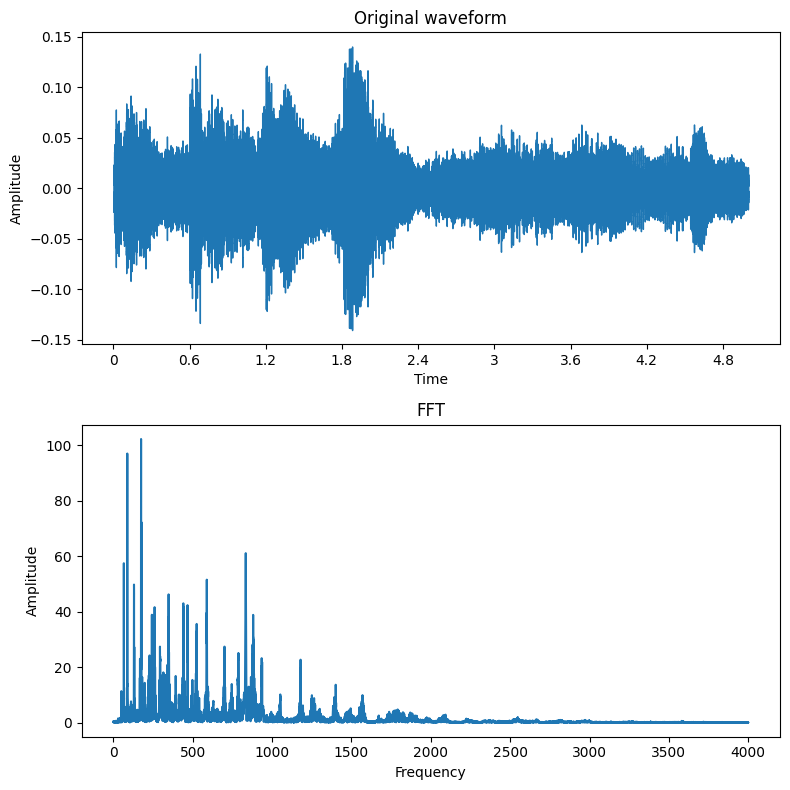

In [5]:
def plot_fft(sample, sr, ax:plt.Axes):
    y = 1/len(sample) * np.abs(np.fft.fft(sample))[:len(sample)//2]
    y = np.abs(np.fft.fft(sample))[:len(sample)//2]
    x = np.linspace(0.0,sr/2.0,len(sample)//2)
    ax.plot(x,y)

fig, axes = plt.subplots(2,1,figsize=(8,8))
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=axes[0])
axes[0].set_title("Original waveform")
axes[0].set_ylabel("Amplitude")

plot_fft(samples2[0].numpy(),SAMPLING_RATE,axes[1])
axes[1].set_title("FFT")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Frequency")
fig.tight_layout()
plt.close()
fig

We have amplitude over time in our original data, and the magnitude of each frequency given by FFT, why not use these together?

## Spectrogram

Let's try to reduce the problem from an audio classification to image classification

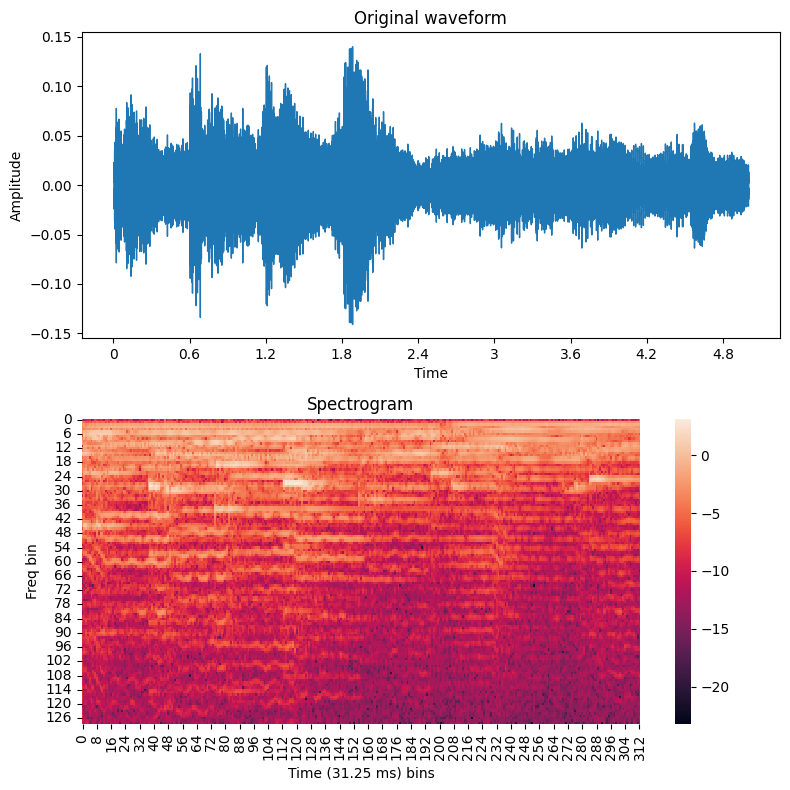

In [8]:
from Dataset import spectrogram as Dataset_spectrogram
import torchvision

fig, axes = plt.subplots(2,1,figsize=(8,8))
fig.tight_layout()

#assuming bpm on average to be around ~120 and no note faster than a 64th-note 
#a note should not be shorter than ~31.25 ms
spec = Dataset_spectrogram(samples2,SAMPLING_RATE)


librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=axes[0])
axes[0].set_title("Original waveform")
axes[0].set_ylabel("Amplitude")

sns.heatmap(spec[0],ax=axes[1])
axes[1].set_title("Spectrogram")
axes[1].set_xlabel("Time (31.25 ms) bins")
axes[1].set_ylabel("Freq bin")
fig.tight_layout()
plt.close()
fig

# Training p.t 2

In [61]:
# Mode 1: spectrogram + flattening of samples
train_ds,train_loader = get_dataloader(train_x,train_y,128,mode=1,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,val_y,100,mode=1,cache_size=200)
train_ds[0][0].shape

torch.Size([40377])

### Linear models 

In [62]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier
from params import *

composer = Perceptron(n_jobs=-1)
instrument = MultiOutputClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)
#linear SVM like algorithm
composer = SGDClassifier(loss='hinge',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
#logistic-regression like algorithm
instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)

#Similar to SVM but supports probabilistic results 
composer = SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)




models2 = [model1,model2,model3]

In [63]:
models2, hist_comp2, hist_inst2, hist_models2 = train_loop(models2,train_loader,val_loader,epoches=EPOCHS)

EPOCH 0
train model 0:
exact match: 5.57%    accuracy composer: 33.62%    exact accuracy instrument: 14.13%
combined accuracy: 53.77%    accuracy instrument: 73.92% ->  ['68.52%', '89.29%', '75.37%', '77.73%', '58.03%', '70.24%', '70.24%', '75.59%', '78.37%', '75.80%']
train model 1:
exact match: 9.42%    accuracy composer: 43.04%    exact accuracy instrument: 14.99%
combined accuracy: 58.15%    accuracy instrument: 73.25% ->  ['66.81%', '85.65%', '76.45%', '82.87%', '59.53%', '70.66%', '71.09%', '74.09%', '73.23%', '72.16%']
train model 2:
exact match: 10.28%    accuracy composer: 41.76%    exact accuracy instrument: 15.63%
combined accuracy: 59.28%    accuracy instrument: 76.81% ->  ['74.52%', '89.94%', '80.73%', '87.37%', '61.67%', '77.09%', '62.53%', '77.73%', '80.94%', '75.59%']

val model 0:
exact match: 4.76%    accuracy composer: 29.67%    exact accuracy instrument: 9.52%
combined accuracy: 51.54%    accuracy instrument: 73.41% ->  ['64.84%', '85.71%', '73.99%', '88.28%', '43.9

What if an instrument wasn't played in the interval?

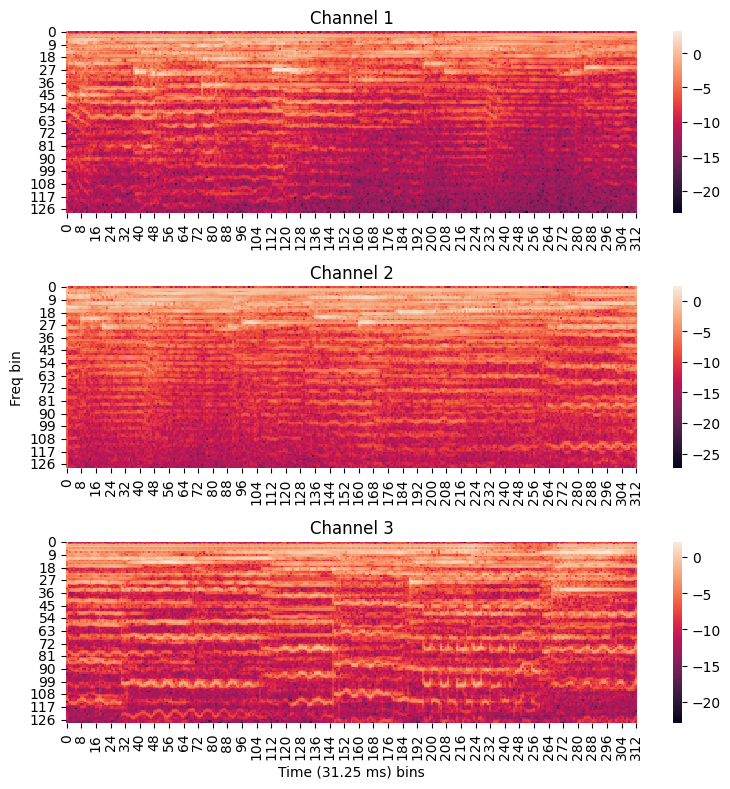

In [64]:
fig, axes = plt.subplots(3,1,figsize=(8,8))
fig.tight_layout()


s,sr = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=(AUDIO_EXAMPLE_OFFSET_SEC+3)*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples3 = torchaudio.functional.resample(s,sr,SAMPLING_RATE)
s,sr = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=(AUDIO_EXAMPLE_OFFSET_SEC+8)*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples4 = torchaudio.functional.resample(s,sr,SAMPLING_RATE)

spec3 = Dataset_spectrogram(samples3,SAMPLING_RATE)
spec4 = Dataset_spectrogram(samples4,SAMPLING_RATE)


disp = sns.heatmap(spec[0],ax=axes[0])
disp = sns.heatmap(spec3[0],ax=axes[1])
disp = sns.heatmap(spec4[0],ax=axes[2])


axes[0].set_title("Channel 1")
axes[1].set_title("Channel 2")
axes[2].set_title("Channel 3")

axes[2].set_xlabel("Time (31.25 ms) bins")
axes[1].set_ylabel("Freq bin")

fig.tight_layout()
plt.close()
fig

### CNN


In [65]:
from params import *
from Dataset import get_dataloader
# mode 2 keeps the spectrogram as an image. we also load up to 200 samples onto the gpu

train_ds,train_loader = get_dataloader(train_x,train_y,64,mode=2,device=DEVICE,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,val_y,64,mode=2,device=DEVICE,cache_size=200)
train_ds[0][0].shape


torch.Size([4, 128, 312])

In [66]:
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
import torch


model_composer = nn.Sequential(
    nn.Conv2d(N_CHANNELS,16,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(16),

    nn.Conv2d(16,16,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(16),

    nn.Conv2d(16,32,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),

    nn.Conv2d(128,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(128),

    
    nn.Flatten(),
    nn.Linear(8*8*128,len(COMPOSER_CLASSES)),
    
)



model_instruments = nn.Sequential(
    nn.Conv2d(N_CHANNELS,16,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(16),

    nn.Conv2d(16,16,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(16),

    nn.Conv2d(16,32,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(INSTRUMENT_CLASSES)),
    
)
opt_composer = torch.optim.Adam(model_composer.parameters(),lr=COMPOSER_LEARNING_RATE,betas=(BETA1,BETA2))
opt_instrument = torch.optim.Adam(model_instruments.parameters(),lr=INSTRUMENT_LEARNING_RATE,betas=(BETA1,BETA2))

#### training loop

In [67]:
from torch.functional import F
import torch

def check_accuracy(model_composer,model_instruments, data_loader, name="",verbose=2):
	num_correct_1 = 0
	num_correct_2 = torch.zeros(len(INSTRUMENT_CLASSES),device=DEVICE)
	num_correct_3 = 0
	num_correct_4 = 0

	num_samples = 0
	
	model_composer.eval()  # set model to evaluation mode
	model_instruments.eval()
	
	with torch.no_grad():
		for x, y in data_loader:
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)

			comp_pred = torch.argmax(nn.Softmax(dim=1)(comp_scores),1)
		
			inst_pred = nn.Sigmoid()(inst_scores) > 0.5
			
			num_correct_1 += torch.sum(comp_pred==y1)
			num_correct_2 += torch.sum(inst_pred == (y2>0.5),0)
			num_correct_3 += torch.sum(torch.prod(inst_pred == (y2>0.5),1))
			correct_1 = comp_pred==y1
			correct_2 = torch.prod(inst_pred == (y2>0.5),1) == 1
			num_correct_4 += torch.sum(correct_1 * correct_2)
			
			num_samples += len(x)

			
			
	comp_accuracy = (num_correct_1/num_samples).cpu().numpy()
	inst_accuracies = (num_correct_2/num_samples).cpu().numpy()
	inst_exact_accuracy = (num_correct_3/num_samples).cpu().numpy()
	exact_accuracy = (num_correct_4/num_samples).cpu().numpy()
	overall_accuracy = ((comp_accuracy + np.mean(inst_accuracies))/2)

	
	if verbose > 0:
		printPerformance(comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy, level=verbose,name = name)
	return  comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy



def train_nn(model_composer:nn.Sequential, model_instruments:nn.Sequential,
		  loader_train, loader_val,
		  optimizer_comp:torch.optim, optimizer_inst:torch.optim,
		  lossFunction_comp=F.cross_entropy, lossFunction_inst=F.multilabel_soft_margin_loss, 
		  verbose = 0,save_checkpoints=None,eval_every=EVAL_EVERY, epoches=EPOCHS):
	
	hist_comp = {"train_loss":{},"train_accuracy":{},"val_accuracy":{}}
	hist_inst= {"train_loss":{},"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}}
	hist_model = {"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}}
	model_composer = model_composer.to(device=DEVICE)
	model_instruments = model_instruments.to(device=DEVICE)
	for e in range(epoches):
		if verbose > 0:
			print('EPOCH %d' % (e))
			
		start = time.time()
		for i, (x, y) in enumerate(loader_train):

			model_composer.train()  # put model to training mode
			model_instruments.train()  
			
			optimizer_comp.zero_grad()
			optimizer_inst.zero_grad()
			
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  
			comp_loss = lossFunction_comp(comp_scores,y1)
			inst_loss = lossFunction_inst(inst_scores,y2)

			comp_loss.backward()
			inst_loss.backward()
			
			hist_comp["train_loss"][e] = comp_loss.item()
			hist_inst["train_loss"][e] = inst_loss.item()

			optimizer_comp.step()
			optimizer_inst.step()
			

		
		
		if verbose > 0:
			new_verb = verbose + int(e%eval_every == 0 or e==epoches-1) - 2
			acc1,acc2,acc3,acc4,acc5 = check_accuracy(model_composer,model_instruments,loader_train,"train",verbose=new_verb)
			if verbose > 2:
				print('composer model loss: = %.4f, instrument model loss:  %.4f' % (comp_loss.item(), inst_loss.item()))
			hist_comp["train_accuracy"][e]=acc1
			hist_inst["train_accuracy"][e]=acc2
			hist_inst["train_accuracy_exact"][e] = acc3
			hist_model["train_accuracy_exact"][e] = acc4
			hist_model["train_accuracy"][e] = acc5

		if verbose>0 and (e%eval_every == 0 or e==epoches-1):
			acc1,acc2,acc3,acc4,acc5  = check_accuracy(model_composer,model_instruments,loader_val,"val",verbose=verbose-1)
			
			hist_comp["val_accuracy"][e]=acc1
			hist_inst["val_accuracy"][e]=acc2
			hist_inst["val_accuracy_exact"][e] = acc3
			hist_model["val_accuracy_exact"][e] = acc4
			hist_model["val_accuracy"][e] = acc5
			if save_checkpoints != None:
				torch.save(model_composer,"checkpoints/composer/"+save_checkpoints+str(e)+".pth")
				torch.save(model_instruments,"checkpoints/instrument/"+save_checkpoints+str(e)+".pth")
			
		if verbose > 0:
			print("epoch time:",time.time()-start)

		if verbose>1 and (e%eval_every == 0 or e==epoches-1):
			print("----------------------------------------------")
			print("")
			print("")
			

	return model_composer, model_instruments, hist_comp, hist_inst, hist_model

#### fitting

In [68]:
model_composer, model_instruments, hist_comp3, hist_inst3, hist_models3 = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=4,save_checkpoints="first",eval_every=EVAL_EVERY,epoches=EPOCHS)

EPOCH 0
train:
exact match: 0.00%    accuracy composer: 14.29%    exact accuracy instrument: 0.00%
combined accuracy: 29.42%    accuracy instrument: 44.55% ->  ['41.68%', '49.75%', '38.49%', '69.58%', '21.51%', '24.03%', '16.81%', '25.38%', '76.30%', '82.02%']
composer model loss: = 1.6478, instrument model loss:  0.5188
val:
exact match: 0.00%    accuracy composer: 14.29%    exact accuracy instrument: 0.00%
combined accuracy: 29.63%    accuracy instrument: 44.98% ->  ['39.93%', '58.97%', '35.53%', '63.74%', '25.27%', '26.37%', '15.75%', '24.54%', '75.46%', '84.25%']
epoch time: 8.773500680923462
----------------------------------------------


EPOCH 1
train:
exact match: 2.18%    accuracy composer: 14.79%    exact accuracy instrument: 3.70%
combined accuracy: 42.68%    accuracy instrument: 70.57% ->  ['42.69%', '79.66%', '65.21%', '72.27%', '23.87%', '79.33%', '84.54%', '89.08%', '82.86%', '86.22%']
composer model loss: = 1.5379, instrument model loss:  0.3805
epoch time: 3.4779994487

# Evaluation
Let's compare the online models and finally choose the best one to use for our testing data

## Model performances during training
### Overall performance
Let's see how well the models performed across both instrument classification and composer at the same time

In [69]:
def plot_models_accuracy_together(hist1,hist2,hist3,axes,train_key = "train_accuracy",val_key="val_accuracy"):
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']
    for i, hist in enumerate(hist1):
        axes[0].plot(hist[train_key].keys(),hist[train_key].values(),color=colors[i])
        axes[1].plot(hist[val_key].keys(),hist[val_key].values(),color=colors[i],label=f"models1 {i}")


    for i, hist in enumerate(hist2):
        axes[0].plot(hist[train_key].keys(),hist[train_key].values(),'--',color=colors[i])
        axes[1].plot(hist[val_key].keys(),hist[val_key].values(),'--',color=colors[i],label=f"models2 {i}")


    axes[0].plot(hist3[train_key].keys(),hist3[train_key].values(),color='g')
    axes[1].plot(hist3[val_key].keys(),hist3[val_key].values(),color='g',label="cnn model")

    axes[0].set_title("Train accuracy")
    axes[1].set_title("Validation accuracy")
    axes[0].set_ylabel("accuracy")

    axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    return axes
from matplotlib.gridspec import GridSpec

def plot_models_accuracy(hist1,hist2,hist3,title="", train_key="train_accuracy",val_key="val_accuracy"):
    fig = plt.figure(figsize=(len(hist1)*3.9,2.3*4))
    gs = GridSpec(4, len(hist1)*2, figure=fig)

    #plotting all models together
    ax1 = fig.add_subplot(gs[0, :len(hist1)])
    ax1.tick_params(labelbottom = False, bottom = False) 
    ax2 = fig.add_subplot(gs[0, len(hist1):],sharey=ax1)
    ax2.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 
    plot_models_accuracy_together(hist1,hist2,hist3,[ax1,ax2],train_key = train_key,val_key=val_key)
    
    #plotting first models
    axes = []
    for i in range(len(hist1)):
        if i == 0:
            axes.append(fig.add_subplot(gs[1, 2*i:2*i + 2]))
            axes[i].tick_params(labelbottom = False, bottom = False) 
        else:
            axes.append(fig.add_subplot(gs[1, 2*i:2*i + 2],sharey=axes[-1]))
            axes[i].tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 
    for i, hist in enumerate(hist1):
        axes[i].plot(hist[train_key].keys(),hist[train_key].values(),label=f"train")
        axes[i].plot(hist[val_key].keys(),hist[val_key].values(),'--',label=f"val")
        axes[i].set_title(f"models1 {i}")
        
    axes[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes[0].set_ylabel("accuracy")

    #second models
    axes2 = []
    for i in range(len(hist1)):
        if i == 0:
            axes2.append(fig.add_subplot(gs[2, 2*i:2*i + 2],sharex=axes[i]))
            axes2[i].tick_params(labelbottom = False, bottom = False) 
        else:
            axes2.append(fig.add_subplot(gs[2, 2*i:2*i + 2],sharex=axes[i],sharey=axes2[-1]))
            axes2[i].tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 

    for i, hist in enumerate(hist2):
        axes2[i].plot(hist[train_key].keys(),hist[train_key].values(),label=f"train")
        axes2[i].plot(hist[val_key].keys(),hist[val_key].values(),'--',label=f"val")
        axes2[i].set_title(f"models2 {i}")
    axes2[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes2[0].set_ylabel("accuracy")

    #final plot of cnn
    ax = fig.add_subplot(gs[3, :])
    ax.plot(hist3[train_key].keys(),hist3[train_key].values(),label="train")
    ax.plot(hist3[val_key].keys(),hist3[val_key].values(),'--',label="val")
    ax.set_title(f"cnn model")

    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set_ylabel("accuracy")
    ax.set_xlabel("epoch")

    fig.suptitle(title)
    fig.tight_layout()
    plt.close()
    return fig

    


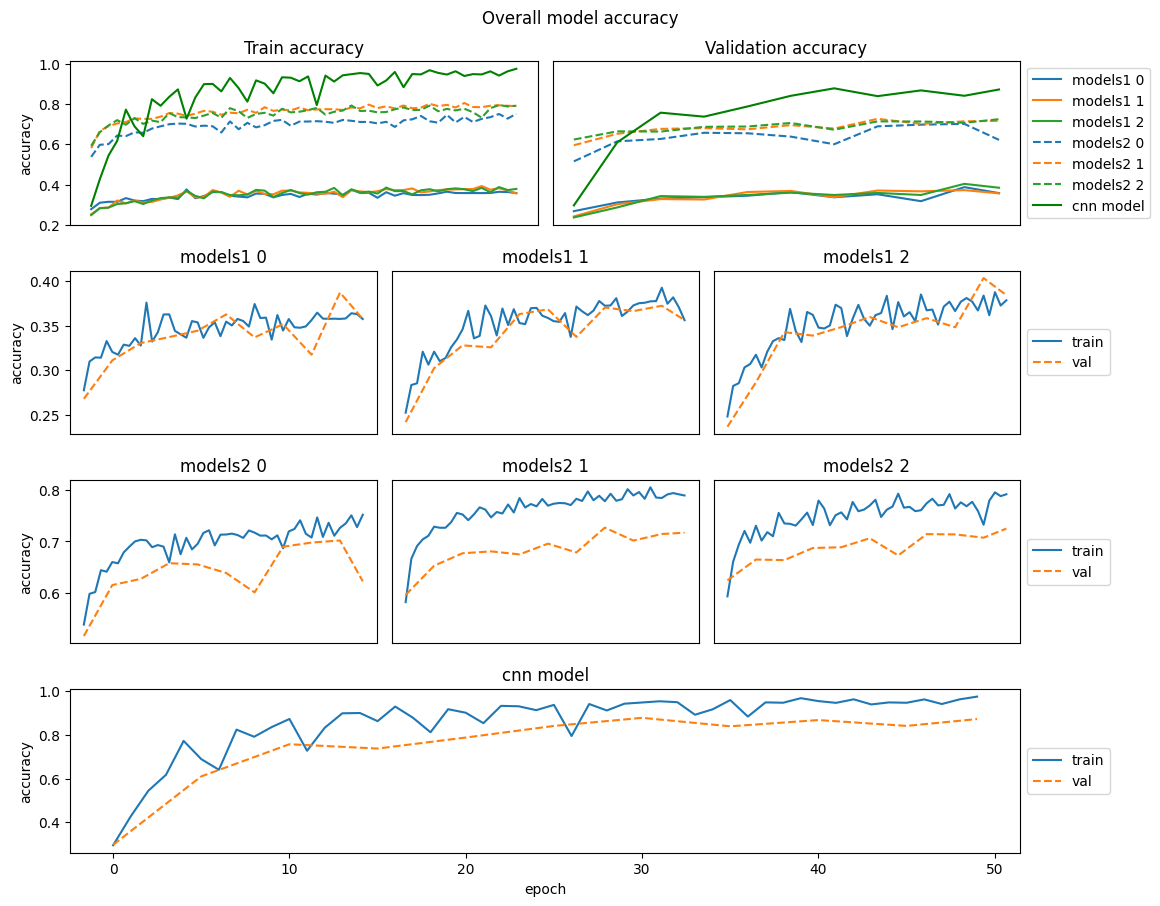

In [70]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,"Overall model accuracy")

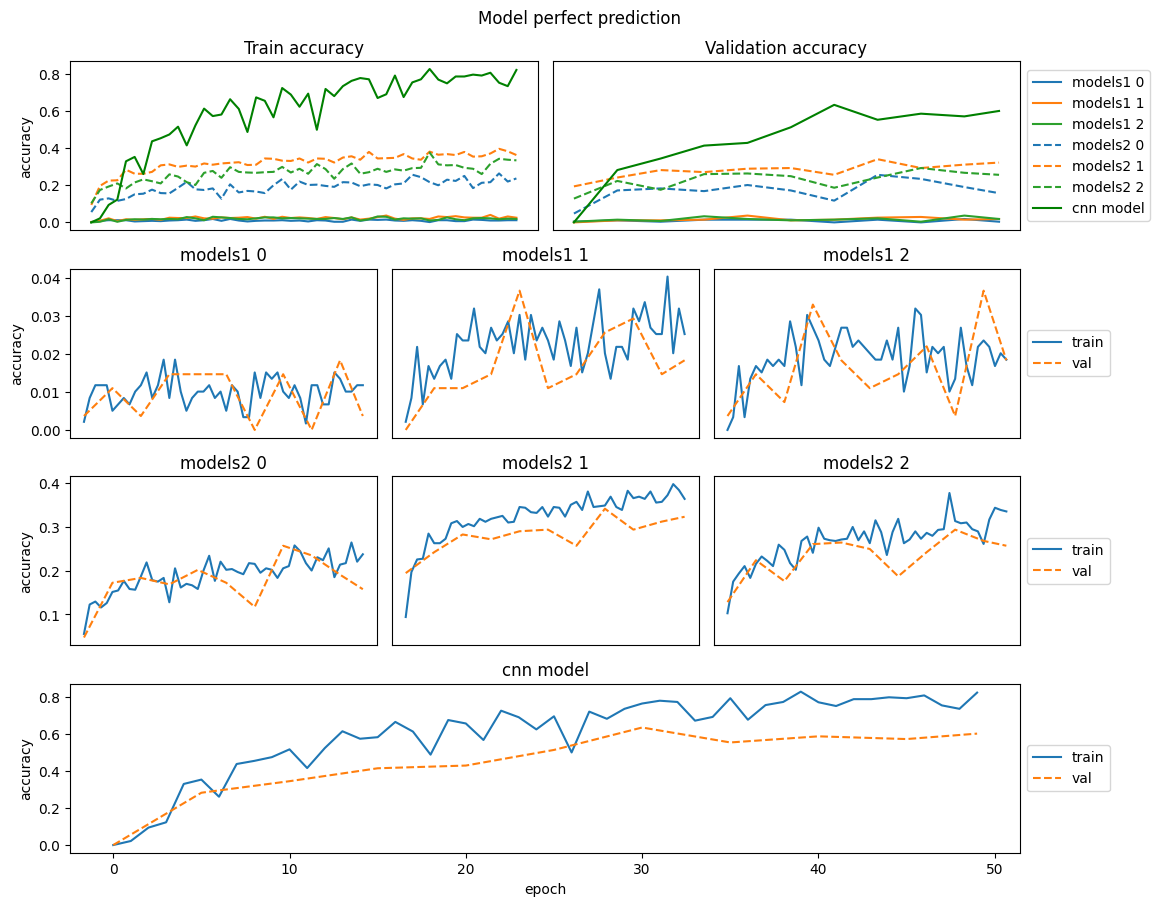

In [71]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Model perfect prediction")

### Composer classification performance
Now let's review the models capabilities to classify composers alone

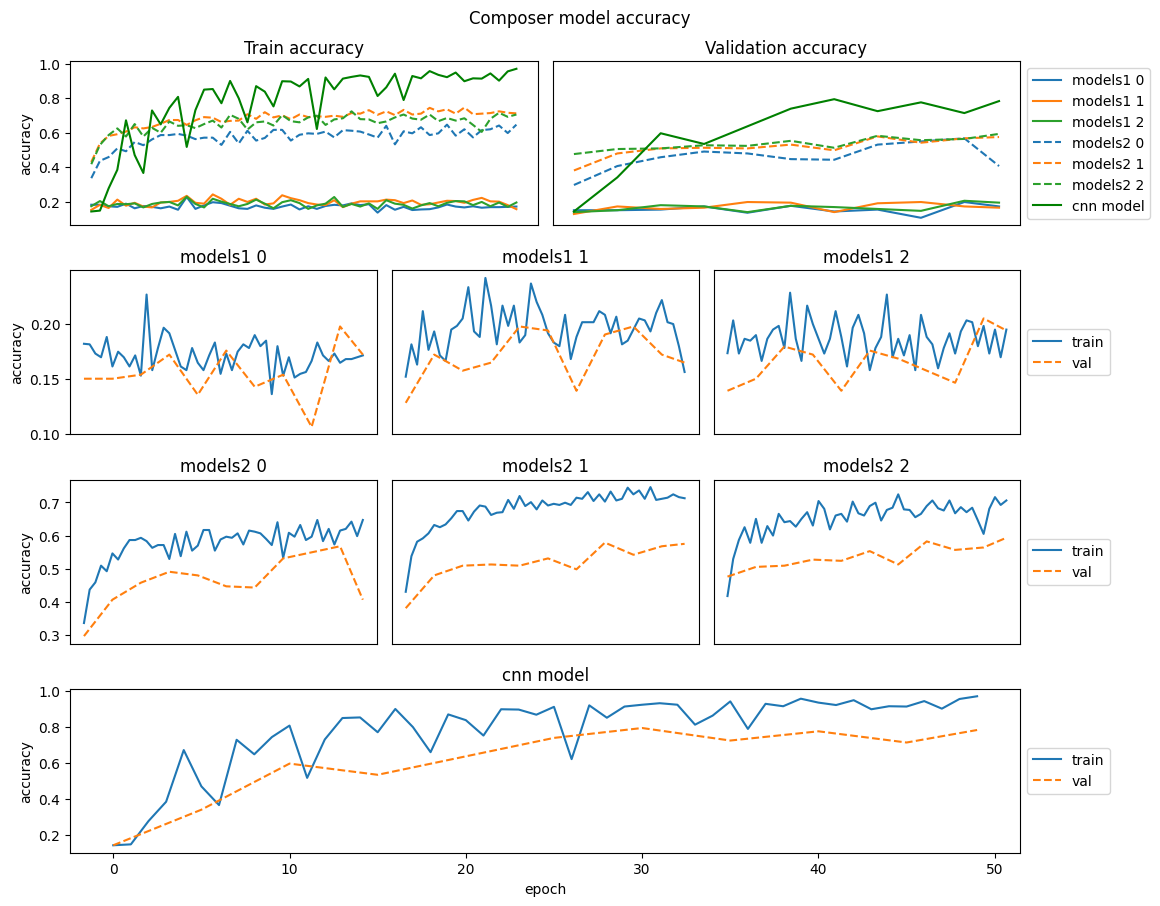

In [72]:
plot_models_accuracy(hist_comp1,hist_comp2,hist_comp3,title="Composer model accuracy")

We can clearly see that transforming the audio data into a spectrogram greatly increased the models performance, it seems that given more epoches, a linear model might come close to the CNN

### Instrument classification performance

First we will look at how good the model is in classifying each instrument alone, then look at how good the model is at perfectly classifying all instruments

In [73]:
def plot_hist_inst(hist,axes,color='g', name=""):
    def get_arr_data(hist):
        accs = []
        for acc in hist.values():
            if type(acc) == torch.Tensor:
                accs.append(acc.numpy())
            else:
                accs.append(acc)
        
        return np.array(accs)

    train_accs = get_arr_data(hist["train_accuracy"])
    val_accs = get_arr_data(hist["val_accuracy"])
    for i in range(train_accs.shape[1]):
        
        axes[i%len(axes), i//len(axes)].plot(hist["train_accuracy"].keys(),train_accs[:,i],label = f"{name} train",color=color)
        axes[i%len(axes), i//len(axes)].plot(hist["val_accuracy"].keys(),val_accs[:,i],'--',label=f"{name} val",color=color)
        axes[i%len(axes), i//len(axes)].set_title(f"instrument {i}")
       


# class InstClassGraph:
    
#     def __init__(self,inst_hists,titles):
#         self.inst_hists = inst_hists
#         self.titles = titles
#         self.ind = 0
        
#         self.colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']


#     def load_graph(self,event:mpl.Event):
#         hists = self.inst_hists[self.ind%len(self.inst_hists)]
#         axes = np.array(event.canvas.figure.axes)[:-2]
#         for ax in axes:
#             ax.clear()
#         axes = axes.reshape(5,2)
        
#         if len(hists) > 1:
#             for i,hist in enumerate(hists):
#                 plot_hist_inst(hist,axes,self.colors[i],name=f"model {i}")
#         else:
#             plot_hist_inst(hists[0],axes)
            
#         axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
#         event.canvas.figure.suptitle(self.titles[self.ind%len(self.inst_hists)])
#         plt.draw()

#     def next(self, event:mpl.Event):
#         print(event)
#         self.ind += 1
#         self.load_graph(event)

#     def prev(self, event:mpl.Event):
#         self.ind -= 1
#         self.load_graph(event)

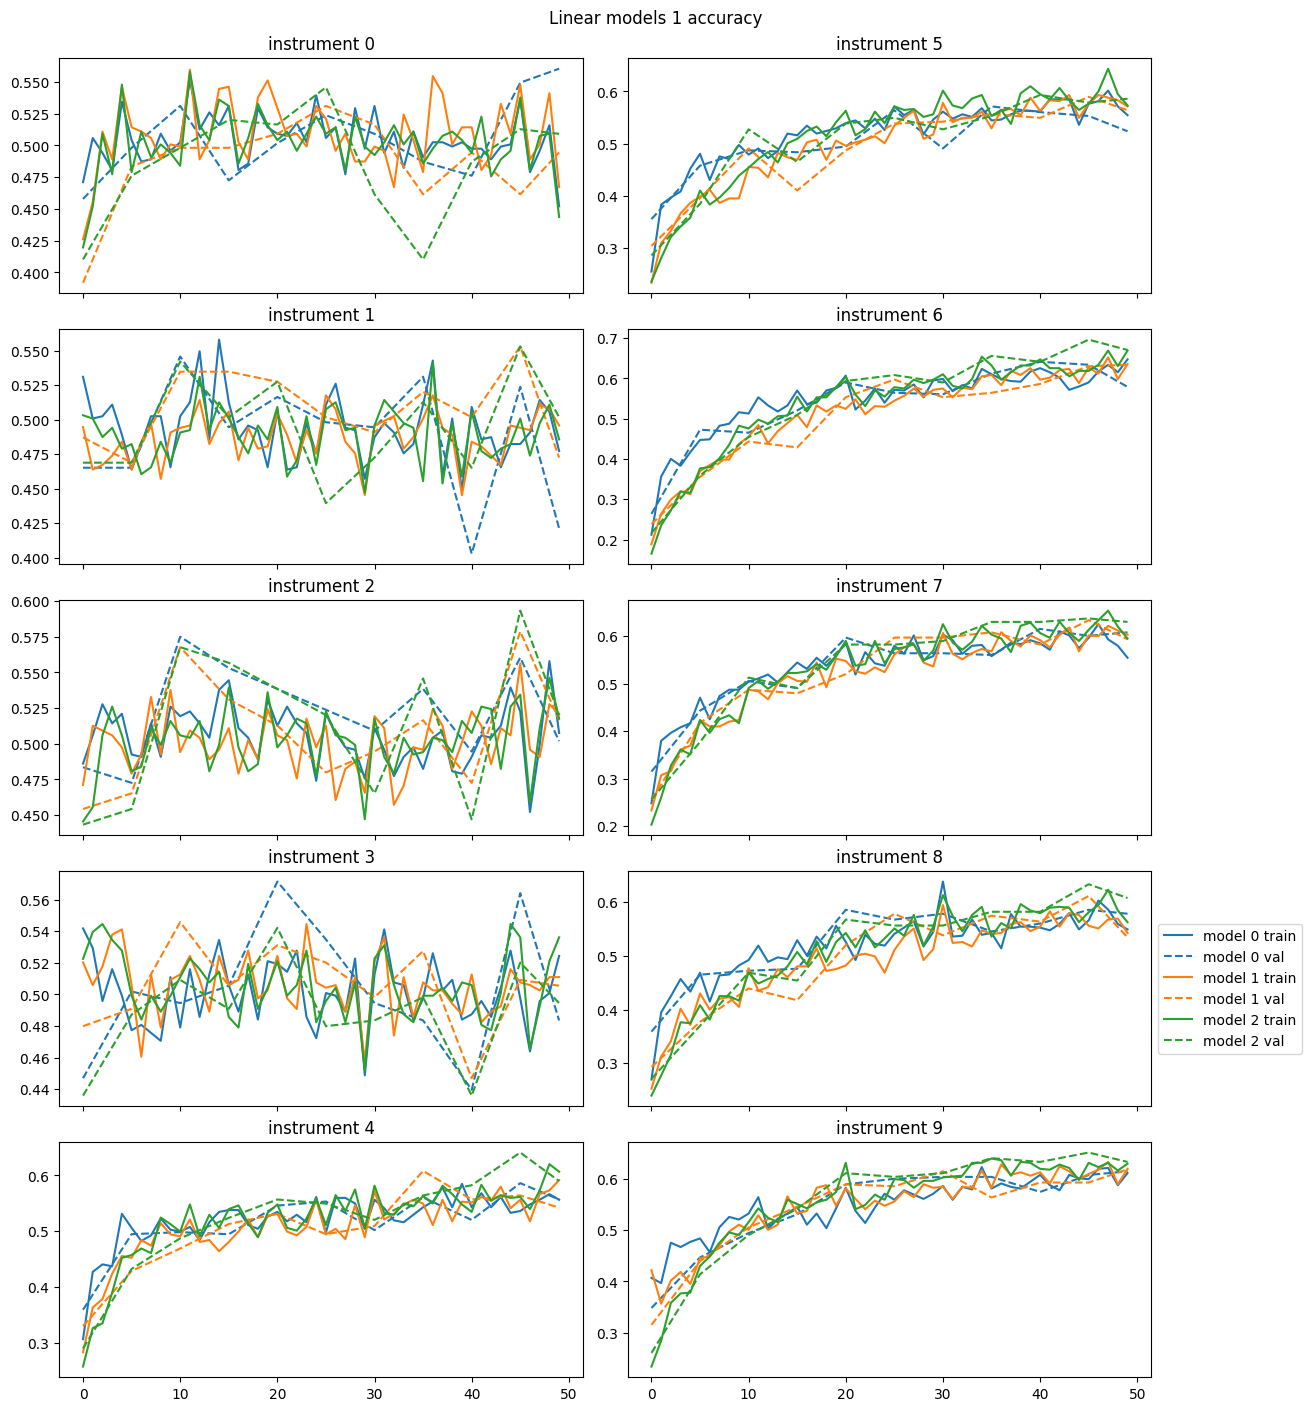

In [74]:
fig, axes = plt.subplots(5,2,figsize=(13,14),sharex=True,sharey=False,constrained_layout=True)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']

for i,hist in enumerate(hist_inst1):
    plot_hist_inst(hist,axes,colors[i],name=f"model {i}")
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
fig.suptitle("Linear models 1 accuracy")
plt.close()
fig

# from matplotlib.widgets import Button
# axprev = fig.add_axes([0.85, 0.05, 0.05, 0.075])
# axnext = fig.add_axes([0.91, 0.05, 0.05, 0.075])

# callback = InstClassGraph([hist_inst1,hist_inst2,[hist_inst3]],titles=["Linear models 1 accuracy","Linear models 2 accuracy","CNN model accuracy"])

# bnext = Button(axnext, 'Next')
# bnext.on_clicked(callback.next)
# bprev = Button(axprev, 'Previous')
# bprev.on_clicked(callback.prev)



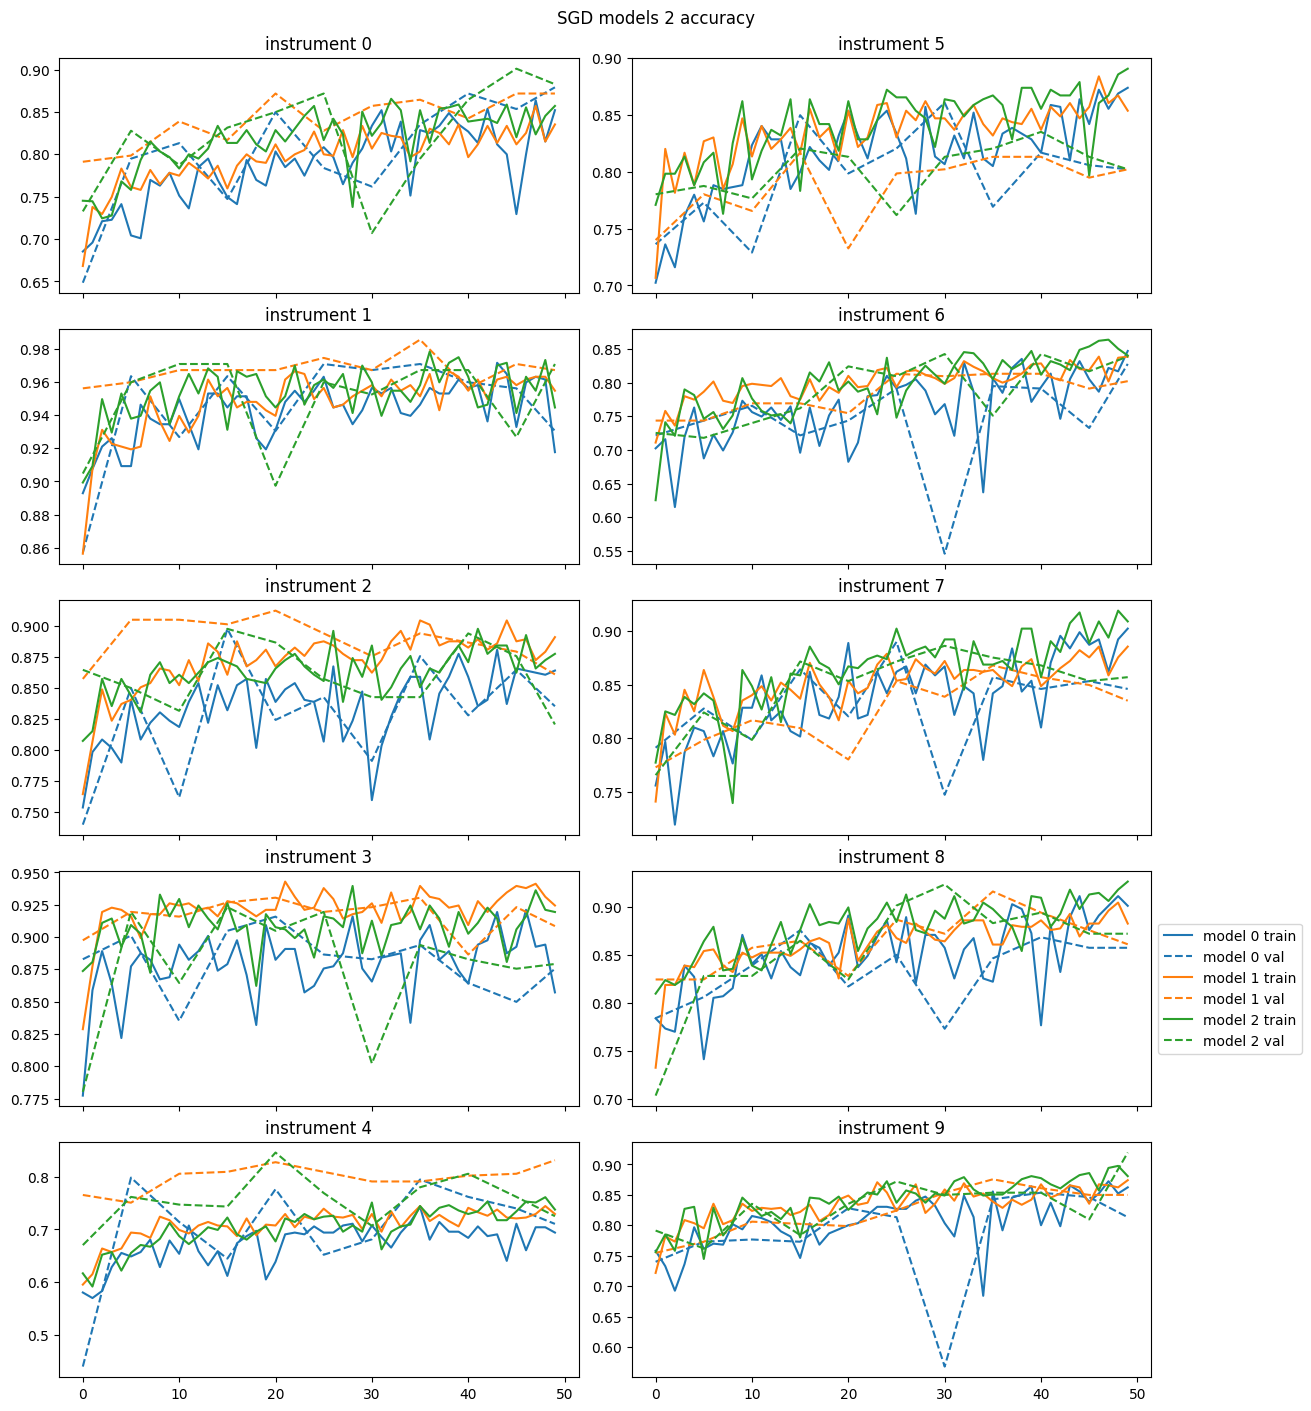

In [101]:
fig, axes = plt.subplots(5,2,figsize=(13,14),sharex=True,sharey=False,constrained_layout=True)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']

for i,hist in enumerate(hist_inst2):
    plot_hist_inst(hist,axes,colors[i],name=f"model {i}")
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
fig.suptitle("SGD models 2 accuracy")
plt.close()
fig

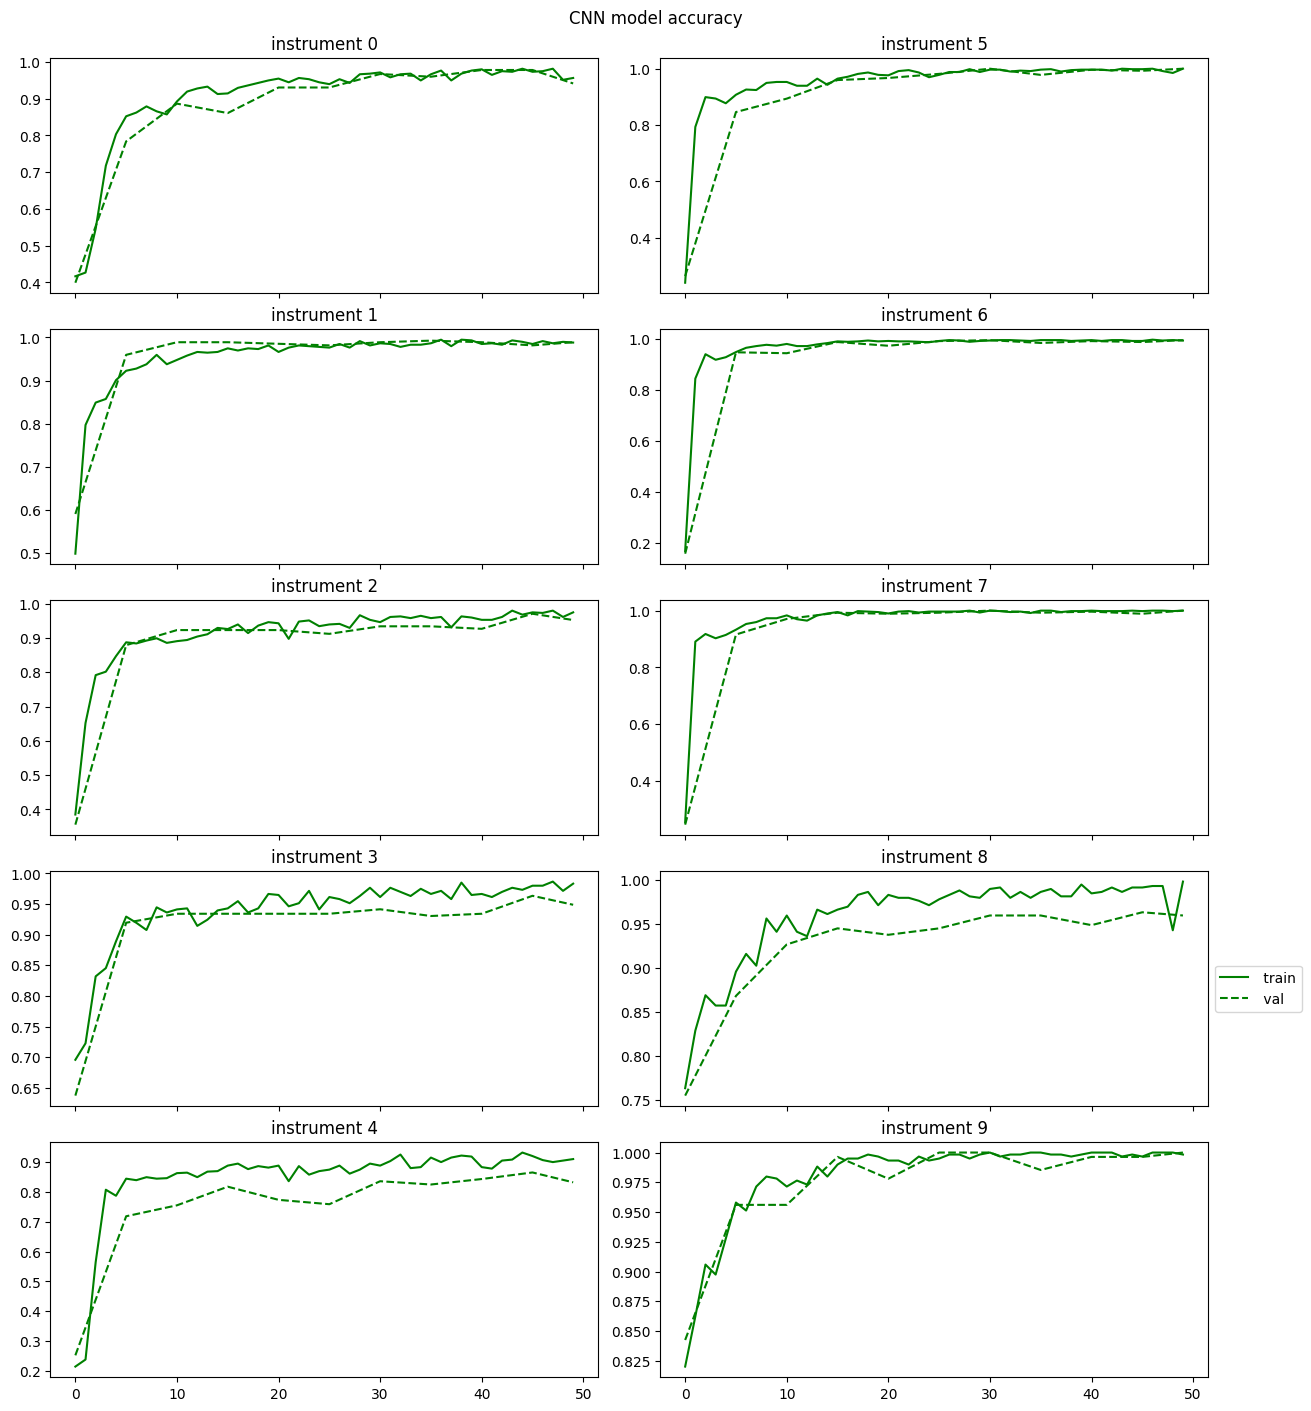

In [76]:
fig, axes = plt.subplots(5,2,figsize=(13,14),sharex=True,sharey=False,constrained_layout=True)

plot_hist_inst(hist_inst3,axes)
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.suptitle("CNN model accuracy")
plt.close()
fig

Let's see how many times the instrument models managed to perfectly classify all instruments

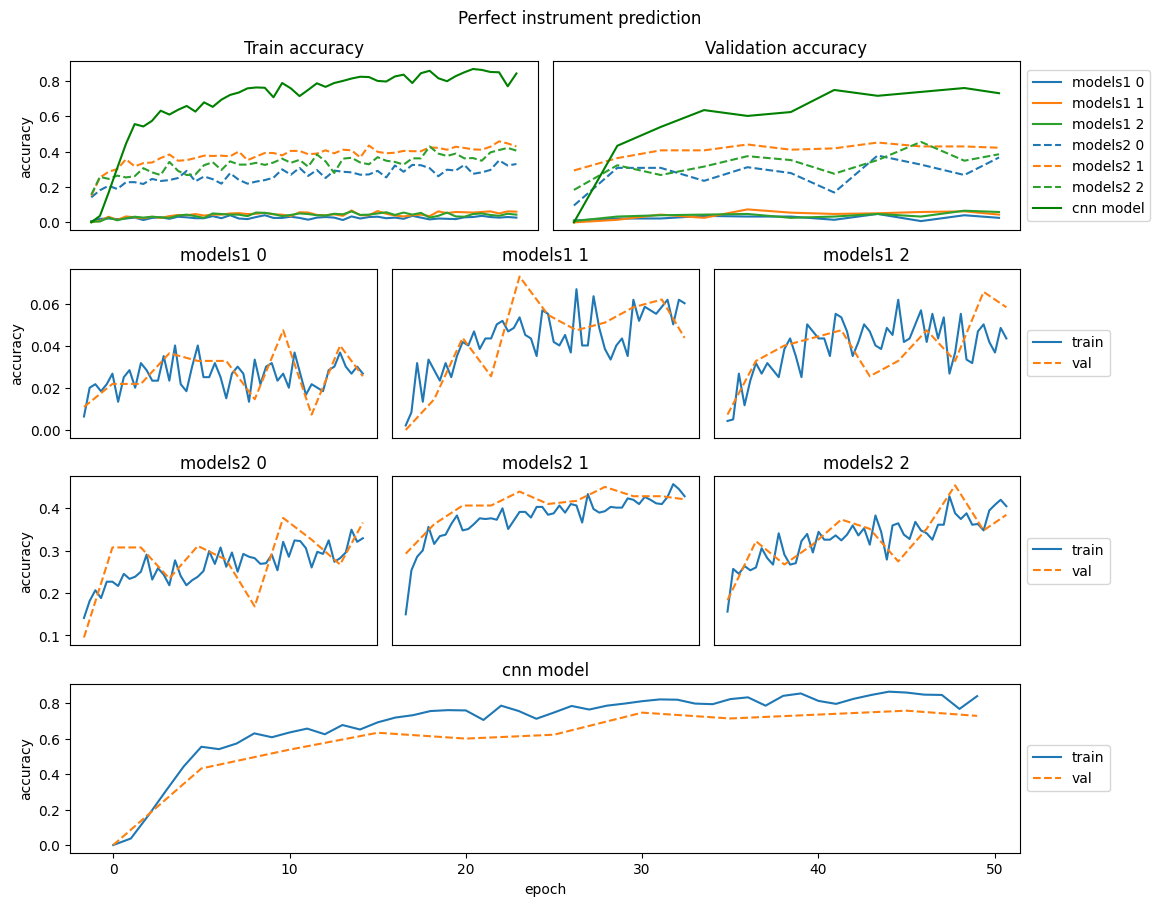

In [77]:
plot_models_accuracy(hist_inst1,hist_inst2,hist_inst3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Perfect instrument prediction")

In all the graphs we saw that the CNN model has the smoothest increase in both train and validation. Since the CNN trains at a much faster rate, I will be training it for some more epoches before testing it.

In [78]:
model_composer, model_instruments, hist_comp4, hist_inst4, hist_models4 = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=4,save_checkpoints="second",eval_every=EVAL_EVERY,epoches=EPOCHS)

EPOCH 0
train:
exact match: 82.35%    accuracy composer: 95.13%    exact accuracy instrument: 86.55%
combined accuracy: 96.66%    accuracy instrument: 98.20% ->  ['97.82%', '98.49%', '97.98%', '97.82%', '92.27%', '99.83%', '99.33%', '100.00%', '98.49%', '100.00%']
composer model loss: = 0.0453, instrument model loss:  0.0368
val:
exact match: 58.24%    accuracy composer: 76.56%    exact accuracy instrument: 75.82%
combined accuracy: 86.74%    accuracy instrument: 96.92% ->  ['97.80%', '98.53%', '98.17%', '94.51%', '85.35%', '99.27%', '99.63%', '99.63%', '97.07%', '99.27%']
epoch time: 4.228999137878418
----------------------------------------------


EPOCH 1
train:
exact match: 83.36%    accuracy composer: 96.81%    exact accuracy instrument: 85.71%
combined accuracy: 97.55%    accuracy instrument: 98.30% ->  ['98.32%', '99.16%', '97.48%', '98.32%', '90.59%', '99.83%', '99.83%', '100.00%', '99.50%', '100.00%']
composer model loss: = 0.0438, instrument model loss:  0.0796
epoch time: 3.

In [79]:
tmp = hist_comp3
def updateHist(hist1,hist2):
    for entry in hist2:
        hist1[entry].update({k+max(hist1[entry].keys()):v for k,v in hist2[entry].items()})

    return hist1

hist_comp = updateHist(hist_comp3,hist_comp4)
hist_inst = updateHist(hist_inst3,hist_inst4)
hist_model = updateHist(hist_models3,hist_models4)


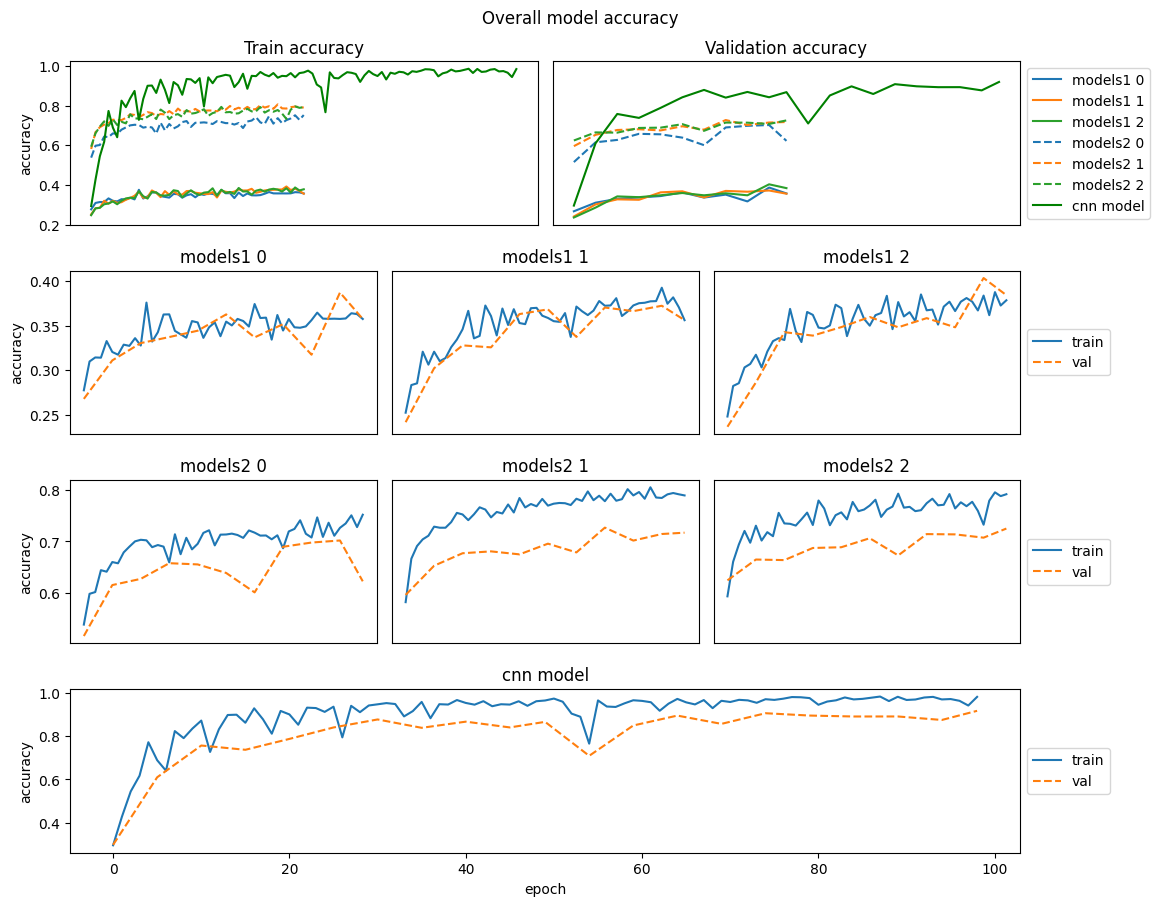

In [80]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,"Overall model accuracy")

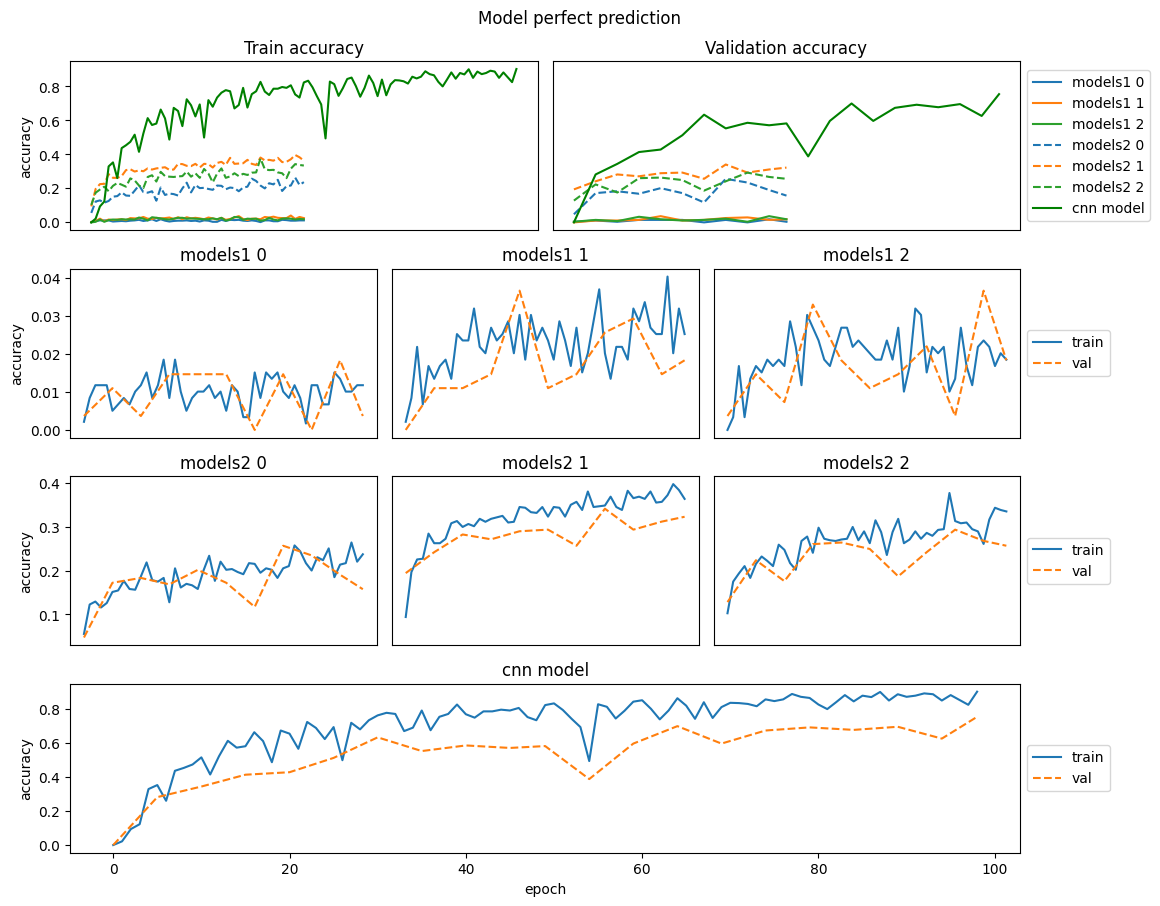

In [81]:
plot_models_accuracy(hist_models1,hist_models2,hist_models3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Model perfect prediction")

# Test

In [82]:
test_ds,test_loader = get_dataloader(test_x,test_y,25,False,mode=2,device=DEVICE,cache_size=200)
test_x.shape

(37,)

In [83]:
def get_model_preds(model_composer,model_instruments, test_loader, factor = 1):
    comp_pred = []
    inst_pred = []
    inst_prob = []
    test_raw_y1 = []
    test_raw_y2 = []
    with torch.no_grad():
        for i in range(factor):
            for x,y in test_loader:
                comp_scores = model_composer(x)
                inst_scores = model_instruments(x)
                test_raw_y1 = test_raw_y1 + y[0].cpu().tolist()
                test_raw_y2 = test_raw_y2 + y[1].cpu().tolist()
                comp_pred = comp_pred + torch.argmax(nn.Softmax(dim=1)(comp_scores),1).cpu().tolist()
                inst_pred = inst_pred + (1*(nn.Sigmoid()(inst_scores) > 0.5)).cpu().tolist()
                inst_prob = inst_prob + nn.Sigmoid()(inst_scores).cpu().tolist()
    test_raw_y1 = np.array(test_raw_y1)
    test_raw_y2 = np.array(test_raw_y2)
    comp_pred = np.array(comp_pred)
    inst_pred = np.array(inst_pred)
    inst_prob = np.array(inst_prob)
    return test_raw_y1,comp_pred, test_raw_y2, inst_pred, inst_prob


#since our test data is small and each sample may have multiple labels, we iterate over the data multiple times
y_real1, comp_pred, y_real2, inst_pred,inst_prob = get_model_preds(model_composer,model_instruments,test_loader,factor=100)
#notice that 
np.unique(y_real1[::len(test_x)])

array([0])

### Composer classification

In [84]:
print(classification_report(y_real1,comp_pred,target_names=encoder.classes_))

              precision    recall  f1-score   support

        Bach       0.99      0.94      0.97       800
   Beethoven       0.89      0.70      0.78      1500
      Brahms       0.59      0.93      0.72       400
     Cambini       0.81      1.00      0.89       100
      Dvorak       0.76      0.96      0.85       100
      Mozart       0.66      0.83      0.73       500
    Schubert       0.76      0.60      0.67       300

    accuracy                           0.80      3700
   macro avg       0.78      0.85      0.80      3700
weighted avg       0.83      0.80      0.81      3700



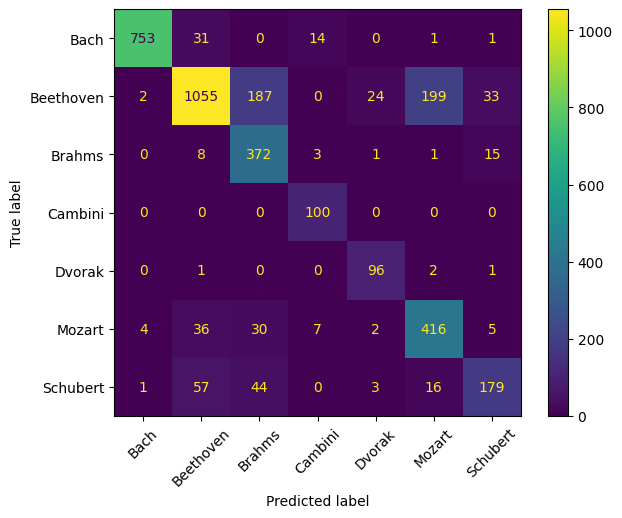

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_real1, comp_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=encoder.classes_)
disp.plot()
disp.figure_.tight_layout()
disp.ax_.tick_params(axis='x',rotation=45)
plt.close()
disp.figure_


### Instrument classification

In [86]:
print(classification_report(y_real2,inst_pred))
print('Exact Match Ratio: {0}'.format(accuracy_score(y_real2,inst_pred)))


              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1800
           1       0.88      0.97      0.92      1900
           2       0.70      0.83      0.76      1000
           3       0.82      0.92      0.87      1600
           4       0.70      0.45      0.55       900
           5       0.95      0.97      0.96       600
           6       0.91      0.60      0.73       200
           7       0.96      0.98      0.97       500
           8       0.98      0.83      0.90       900
           9       0.98      1.00      0.99       200

   micro avg       0.86      0.88      0.87      9600
   macro avg       0.88      0.85      0.86      9600
weighted avg       0.86      0.88      0.86      9600
 samples avg       0.90      0.90      0.88      9600

Exact Match Ratio: 0.5694594594594594


c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


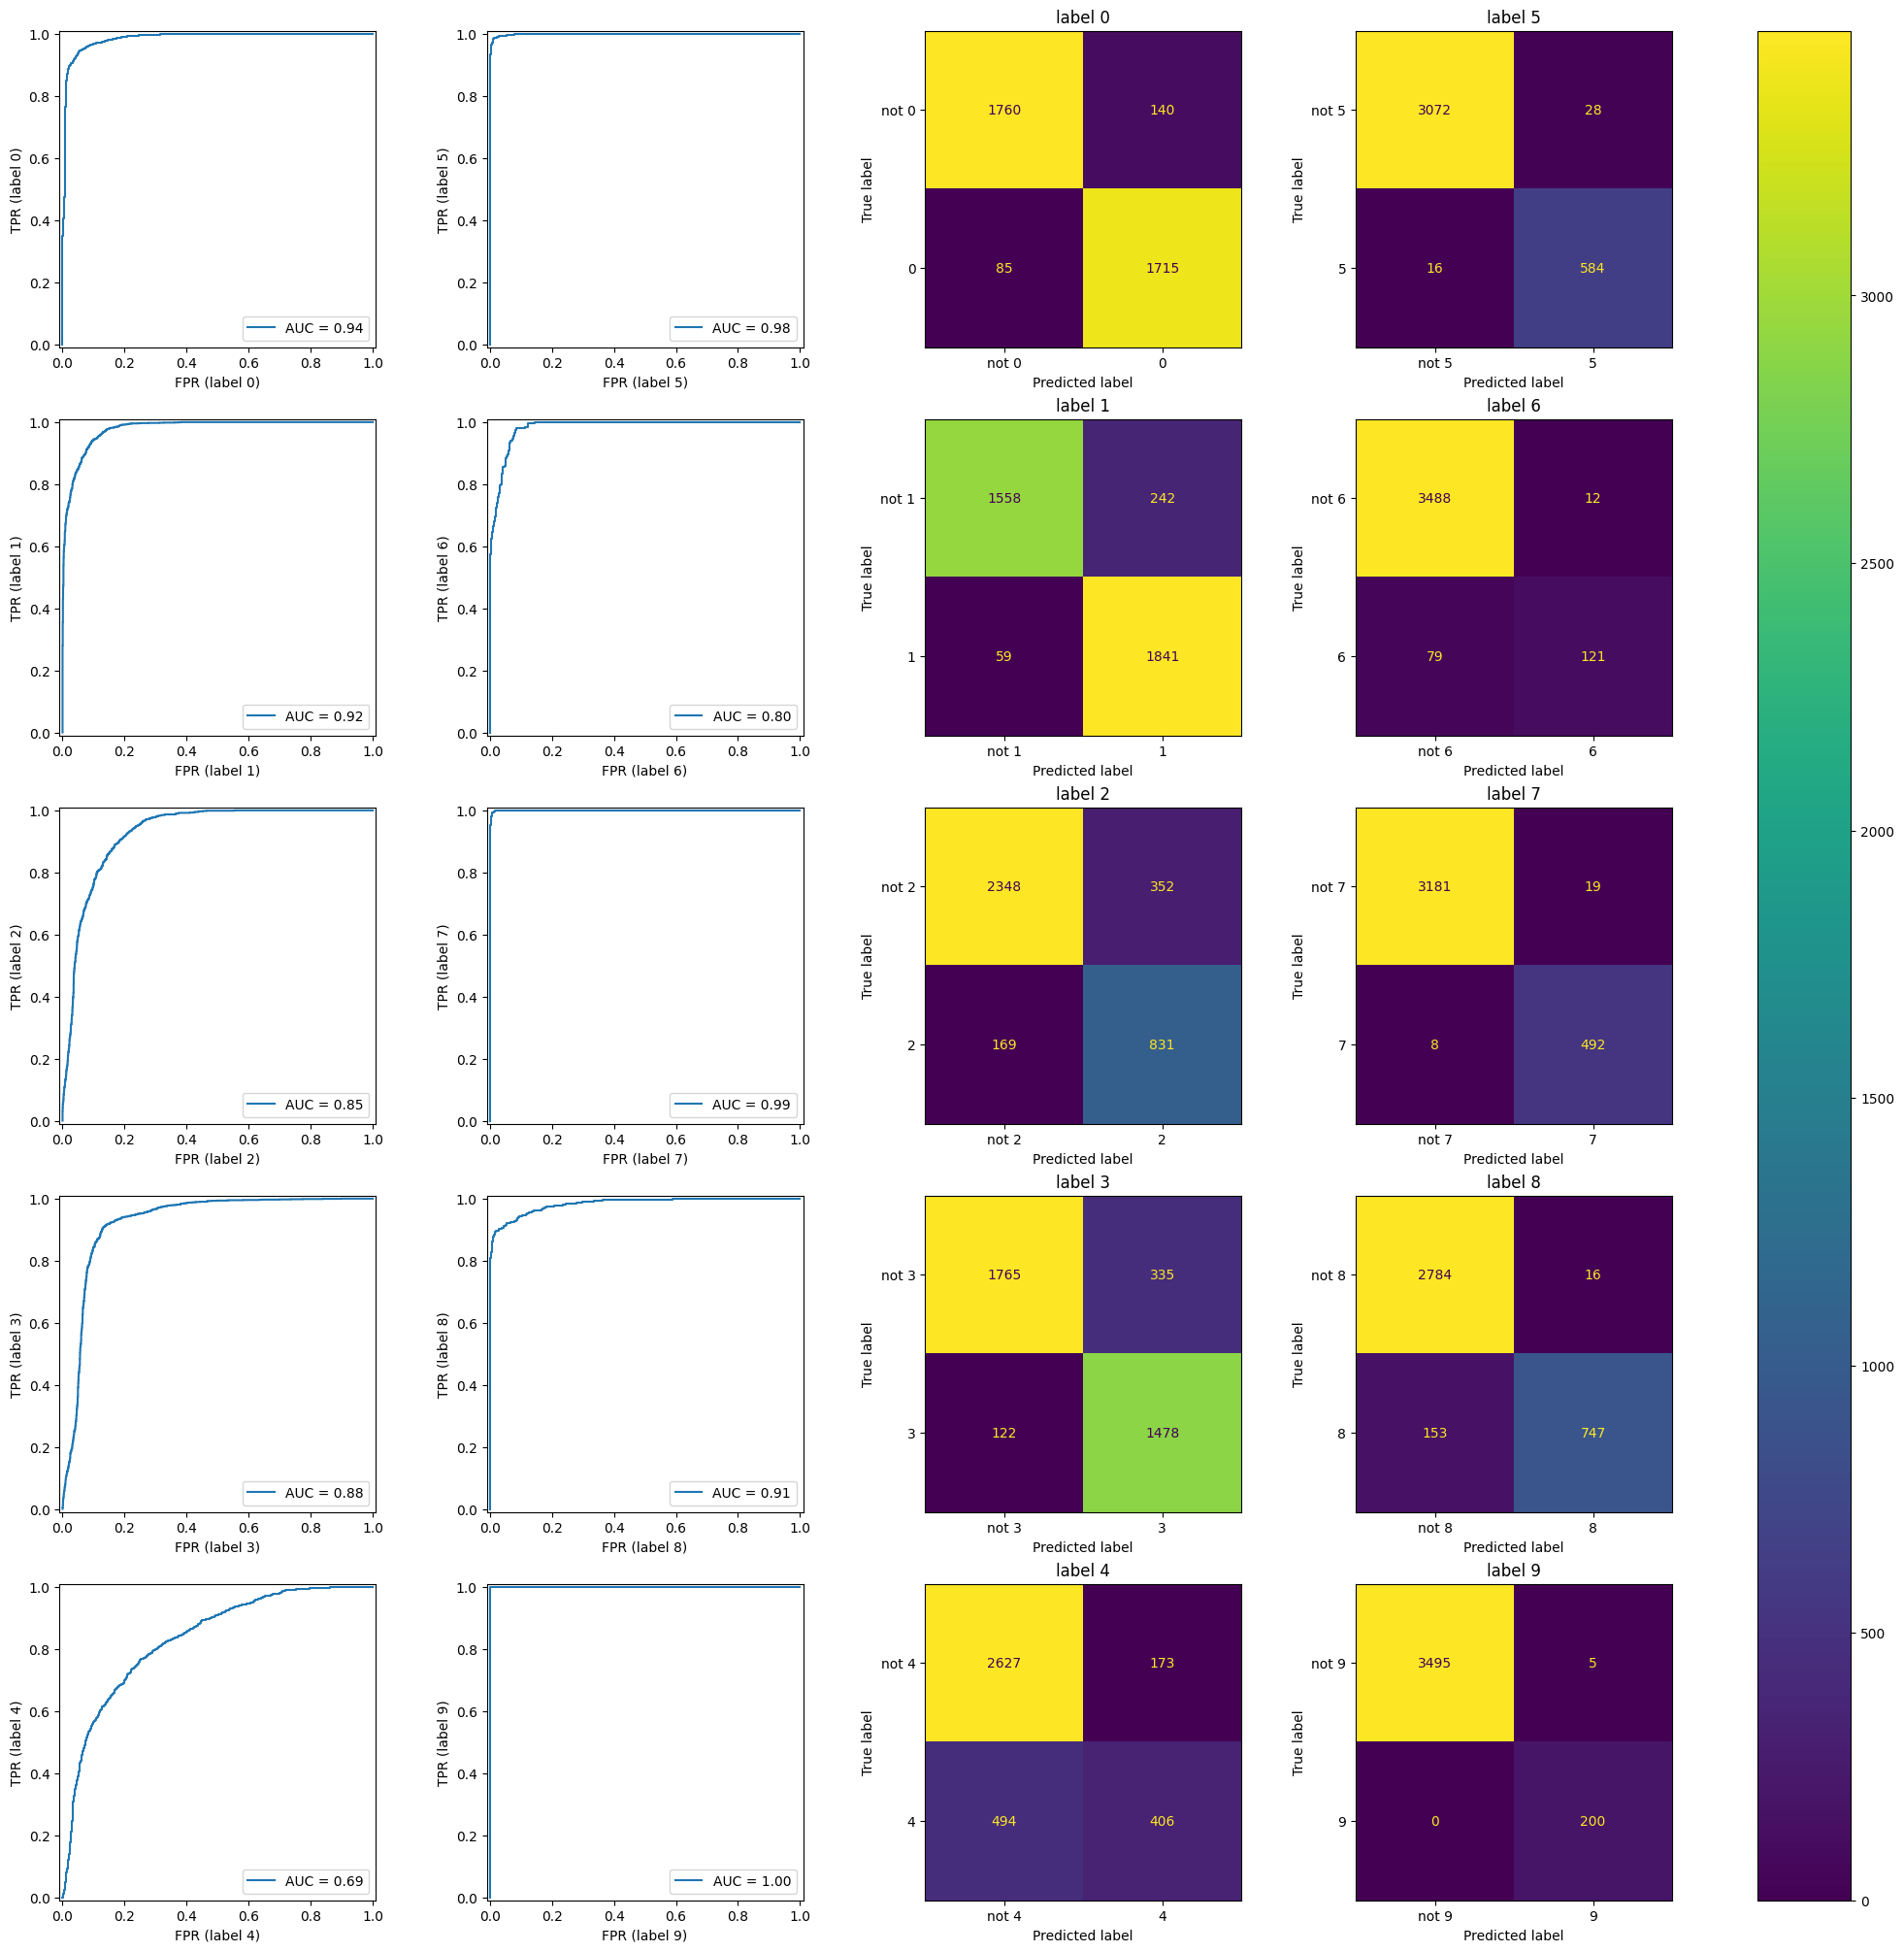

In [87]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

f, axes = plt.subplots(5, 4, figsize=(20,20),layout="constrained")
y_real2 = np.array(y_real2)
inst_pred = np.array(inst_pred)
inst_prob = np.array(inst_prob)

for i in range(10):
    fpr, tpr,thresh = roc_curve(y_real2[:, i],inst_prob[:, i])
    disp = RocCurveDisplay(fpr=fpr,tpr=tpr,pos_label=i,roc_auc=roc_auc_score(y_real2[:, i],inst_pred[:, i]))
    disp.plot(ax=axes[i%5,i//5])
    disp.ax_.set_xlabel(f"FPR (label {i})")
    disp.ax_.set_ylabel(f"TPR (label {i})")

for i in range(10):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_real2[:, i],inst_pred[:, i]),display_labels=[f'not {i}', i])
    disp.plot(ax=axes[i%5,2+i//5], values_format='.4g')
    disp.ax_.set_title(f'label {i}')
    
    disp.im_.colorbar.remove()

#f.tight_layout()
f.colorbar(disp.im_, ax=axes)
plt.close()
f

In [102]:
def any_string(y):
    a = 1*(((y[:,1] > 0) + (y[:,2] > 0) + (y[:,3]>0) + (y[:,4]>0)) > 0)
    y[:,1] = a
    y[:,2] = a
    y[:,3] = a
    y[:,4] = a
    return y
string_y = any_string(y_real2.copy())
string_pred = any_string(inst_pred.copy())

print(classification_report(string_y,string_pred))
print('Exact Match Ratio: {0}'.format(accuracy_score(string_y,string_pred)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1800
           1       0.98      0.96      0.97      2400
           2       0.98      0.96      0.97      2400
           3       0.98      0.96      0.97      2400
           4       0.98      0.96      0.97      2400
           5       0.95      0.97      0.96       600
           6       0.91      0.60      0.73       200
           7       0.96      0.98      0.97       500
           8       0.98      0.83      0.90       900
           9       0.98      1.00      0.99       200

   micro avg       0.97      0.94      0.96     13800
   macro avg       0.96      0.92      0.94     13800
weighted avg       0.97      0.94      0.96     13800
 samples avg       0.98      0.96      0.96     13800

Exact Match Ratio: 0.8472972972972973


c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Composer and instrument classification

In [88]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

bin_comp_pred = lb.fit_transform(comp_pred)
bin_y_real1 = lb.transform(y_real1)
all_real = np.hstack((bin_y_real1,y_real2))
all_pred = np.hstack((bin_comp_pred,inst_pred))

classes = list(encoder.classes_) + [f"{i}" for i in range(len(INSTRUMENT_CLASSES))]

print(classification_report(all_real,all_pred,target_names=classes))
print('Exact Match Ratio: {}'.format(accuracy_score(all_real,all_pred)))


              precision    recall  f1-score   support

        Bach       0.99      0.94      0.97       800
   Beethoven       0.89      0.70      0.78      1500
      Brahms       0.59      0.93      0.72       400
     Cambini       0.81      1.00      0.89       100
      Dvorak       0.76      0.96      0.85       100
      Mozart       0.66      0.83      0.73       500
    Schubert       0.76      0.60      0.67       300
           0       0.92      0.95      0.94      1800
           1       0.88      0.97      0.92      1900
           2       0.70      0.83      0.76      1000
           3       0.82      0.92      0.87      1600
           4       0.70      0.45      0.55       900
           5       0.95      0.97      0.96       600
           6       0.91      0.60      0.73       200
           7       0.96      0.98      0.97       500
           8       0.98      0.83      0.90       900
           9       0.98      1.00      0.99       200

   micro avg       0.85   